# Content
- Data processing/cleaning [Jump](#data)
- The universe to explore [Jump](#universe)
- **Final Strategy** [Jump](#final_strategy)
    - In-sample testing [Jump](#in-sample)
        - Middle 4 years (2010-01-04 to 2013-12-30)
    - Out-sample testing [Jump](#out-sample)
        - Other 16 years
- (Supplemtary Information) Strategies that lead up to the Final Strategy
    - Strategy 1 [Jump](#strategy1)
        - Simple Moving Average (SMA)
        - Cross check correctness of my code[Jump](#correctness)
    - Strategy 2 [Jump](#strategy2)
        - Looking at various parameters of Strategy 1
    - Strategy 3 [Jump](#strategy3)
        - Exponential Weighted Moving Average (EMA) 
        - Linearly Weighted Moving Average (WMA)
        - Smoothed Moving Average (SMMA)
    - Strategy 4 [Jump](#strategy4)
        - Moving Average strategy based on predicted prices

In [1]:
import pandas as pd
import yfinance as yf
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import itertools
import pickle

import warnings
warnings.filterwarnings('ignore')

import backtrader as bt

from sklearn import linear_model
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.feature_selection import chi2, f_regression, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import statsmodels.tsa.arima.model as stats

from statsmodels.tsa.arima.model import ARIMA

In [16]:
df = pd.read_csv('SPY (2003-01 - 2021-11).csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-01-02,88.849998,91.300003,88.540001,91.070000,63.275799,44516300
2003-01-03,90.910004,91.379997,90.500000,91.349998,63.470383,32222600
2003-01-06,91.239998,93.489998,91.169998,92.959999,64.589005,40984500
2003-01-07,92.900002,93.370003,92.199997,92.730003,64.429184,38640400
2003-01-08,92.199997,92.400002,91.050003,91.389999,63.498142,38702200
...,...,...,...,...,...,...
2021-11-17,469.000000,469.190002,467.480011,468.140015,468.140015,47858300
2021-11-18,469.239990,470.010010,466.339996,469.730011,469.730011,50625600
2021-11-19,469.609985,470.940002,468.500000,468.890015,468.890015,57288900


<a id='data'></a>
# Data processing/cleaning

In [17]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

<font color='red'> No missing data </font>

### Compare with Yahoo Finance

In [18]:
start_date = datetime(2003, 1, 2)
end_date = datetime(2021, 11, 23)
sp500_data = yf.download('SPY', start=start_date, end=end_date)

percentage_differences = (df- sp500_data)/ sp500_data* 100

percentage_differences_distribution = percentage_differences.describe()
percentage_differences_distribution

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
count,4.757000e+03,4.757000e+03,4.757000e+03,4.757000e+03,4757.000000,4757.000000
mean,-1.863232e-10,9.340287e-11,9.448195e-09,9.668612e-10,3.529304,-0.000273
std,2.027494e-07,1.991090e-07,2.019183e-07,2.017540e-07,0.000023,0.006023
min,-6.763497e-07,-5.846130e-07,-7.065888e-07,-6.715596e-07,3.529196,-0.231165
25%,-1.404293e-07,-1.377029e-07,-1.270096e-07,-1.391413e-07,3.529290,0.000000
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.529304,0.000000
75%,1.387580e-07,1.369288e-07,1.508772e-07,1.383191e-07,3.529318,0.000000
max,6.831716e-07,5.915422e-07,5.980304e-07,6.351254e-07,3.529401,0.000000


<font color='red'> Differences between data at hand and data from Yahoo Finance are small </font>

In [19]:
print('length of data at hand = ', len(df))
print('length of data from Yahoo Finance = ', len(sp500_data))

length of data at hand =  4758
length of data from Yahoo Finance =  4757


<font color='red'> Between 2003-01-02 and 2021-11-23, the number of days in the data at hand is effecitvely the same as the number of days in data from Yahoo Finance </font>

<a id='universe'></a>
#  The universe to explore 
#### To align with the overall framework of a moving average cross-over strategy
- Delta value
- Types of moving average
- Percentage of capital to invest in each trade

<a id='final_strategy'></a>
# Final Strategy
- <font color='red'> I looked through various multiple variations of moving averages (e.g. EMA, WMA, SMMA, MA calculated using predicted prices), and I conclude that none of the variants delivery significant value-add to the SMA base model, hence the final strategy that I choose is the SMA crossover strategy

- Simple moving averages with periods as 30 days and 365 days
- Delta = 2%
    - Dynamic "stop loss" as a profit protection mechanism
    - 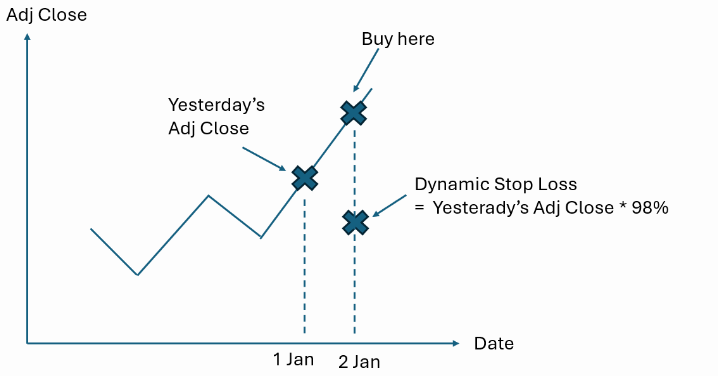
- Initial Capital = $100k (for backtesting purpose)
- Capital per trade is 2% of current capital (not 2% of initial capital)
    - By risking only a small percentage of the total capital on any single trade, a trader ensures that even a series of losses will not significantly impact their overall trading capital. This approach helps in preserving capital, maintaining the trader's ability to continue trading (capital preservation), and reduces the emotional stress associated with large losses.
- Use Adj Close.
    - Adj Close is more appropriate than Close as SPY ETF undego splits. Total return method is more realistic than price return method
- Max 1 position
- Assume that in each day, system can only choose one of the following action: long, short, do nothing. System cannot close a position and immediately on another position on the same day. 

<a id='in-sample'></a>
# In-sample testing
- 4 years (22%) of training data, selecting the middle years
    - 2010-01-04 to 2013-12-30
- Unseen data can be before or after the training data. If strategy captures anything, it should work in period before training data too.
- Don't do full-on numerical optimization as this is overfitting noise. Intuitive hyperparamters are good.  
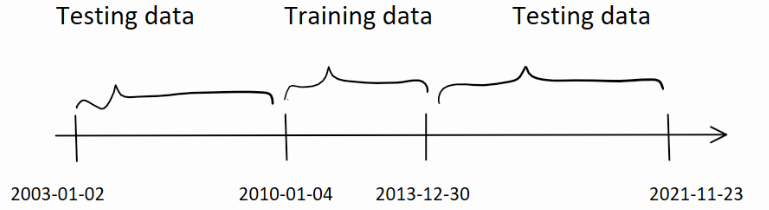

In [4]:
def performance_metrics(df): # df to contain columns cum_pnl, daily_pnl
    ##### Net Profit
    net_profit = round(((df['capital'].iloc[-1] - capital) / capital) * 100)
    print(f'Net Profit = {net_profit}%') # Net profit is directly affected by win rate and the size of wins relative to losses. Increasing win rate and managing losses can improve net profit.

    #### CAGR
    cagr = round(((df['capital'][-1] / capital) ** (252.0 / len(df)) - 1)*100)
    print(f'CAGR = {cagr}%')
    
    ##### Average daily profit
    # (Note) positive is good, but should be considered with other metrics like max drawdown.
    # (Note) Improving the average trade involves refining the strategy to capture larger moves or reducing the size of losses.
    average_pnl = round(df['daily_pnl'].mean()*100)
    print(f'Average daily profit = ${average_pnl}')
    
    ##### Number of trades
    trade_per_year = round(abs(df['action']).sum() / (len(df)/252),1)
    print("Total number of trades per year = ", trade_per_year)
    
    ##### Win Rate
    win_rate = round((df['daily_pnl'] > 0).sum() / df['daily_pnl'].count() * 100) # np.nan in "trade_pnl" col is ignored 
    print(f'Win rate = {win_rate}%')
    # (Note) above 50% is generally good, but it depends on the payoff ratio (average win/average loss).
    # (Note) a higher win rate can be achieved by better market timing, improved trade selection, and more accurate entry/exit points.

    ##### Mean & Standard Deviation of Daily Pnl
    mean = round(df['daily_pnl'].mean()*252)
    std = round(df['daily_pnl'].std()* (252**0.5))
    print(f'Mean of Daily Pnl = ${mean}')
    print(f'Standard Deviation of Daily Pnl = {std}')

    ##### Profitability Ratio (Payoff Ratio)
    average_positive_pnl = round(df['daily_pnl'][df['daily_pnl'] > 0].mean())
    average_negative_pnl = round(df['daily_pnl'][df['daily_pnl'] < 0].mean())
    payoff_ratio = round(average_positive_pnl / abs(average_negative_pnl))
    print(f'Average Positive Pnl($) = ', average_positive_pnl)
    print(f'Average Negative Pnl($) = ', average_negative_pnl)
    print(f'Payout Ratio = ', payoff_ratio)
    
    ##### Sharpe Ratio (measure of risk-adjusted return)
    # (Note) Sharpe Ratio greater than 1 is considered acceptable to good by investors.
    # (Note) Increasing the average returns or reducing volatility (standard deviation of returns) can improve the Sharpe Ratio
    # (Note) higher Sharpe Ratio indicates a more efficient strategy with better risk-adjusted returns, contributing to the pursuit of 'true alpha'
    rf_rate = 0.0 
    daily_risk_free_return = (1 + rf_rate) ** (1/252) - 1
    excess_daily_return = df['daily_pnl'] / df['capital'] - daily_risk_free_return
    sharpe_ratio = round((excess_daily_return.mean() / excess_daily_return.std()) * (252 ** 0.5)) # Annualizing the Sharpe ratio
    print(f'Sharpe Ratio = {sharpe_ratio}%')
    
    ##### Sortino Ratio (similar to the Sharpe ratio but only considers downside volatility)
    # (Note) Sortino Ratio greater than 1 is good; higher than 2 is very good.
    # (Note) Focus on strategies that avoid large drawdowns, as this will reduce downside deviation and improve the Sortino Ratio.
    # (Note) An improved Sortino Ratio means the strategy is effectively managing downside risk, which is important for long-term capital growth.
    target_return = 0  # Target return could be set to 0 or the risk-free rate
    downside_returns = df[df['daily_pnl'] < target_return]['daily_pnl']
    downside_deviation = downside_returns.std()
    sortino_ratio = round((excess_daily_return.mean() / downside_deviation) * (252 ** 0.5))
    print(f'Sortino Ratio = {sortino_ratio}%')

    ##### Beta
    # Beta = 1: The security's price moves exactly in line with the market.
    # Beta > 1: The security's price fluctuates more than the market (more volatile).
    # Beta < 1: The security's price fluctuates less than the market (less volatile).
    # Beta = 0: The security's price has no correlation with the market.
    # Beta < 0: The security's price moves opposite to the market (inversely correlated).
    # beta can range from negative infinity (-∞) to positive infinity (+∞). However, in practical terms, most stocks have betas between -3 and 3
    # Extremely volatile stocks may have betas much higher than 3.
    # Securities with very little risk (like government bonds) might have betas close to zero.
    market_returns_pct = df[['Adj Close']].pct_change()
    market_returns_pct = market_returns_pct.rename(columns={'Adj Close': 'market_returns_pct'})
    strategy_daily_pnl_pct = (df['position'] * df['close_change_pct']).to_frame()
    strategy_daily_pnl_pct = strategy_daily_pnl_pct.rename(columns={0: 'strategy_daily_pnl_pct'})
    merged_df = strategy_daily_pnl_pct.join(market_returns_pct, how='inner', lsuffix='_df', rsuffix='_market').dropna()
    beta = round(np.cov(merged_df['strategy_daily_pnl_pct'], merged_df['market_returns_pct'])[0][1] / np.var(merged_df['market_returns_pct']), 2) # np.cov() returns a 2x2 covariance matrix where [0][1] us covariance between daily_pnl and Adj Close 
    print("Beta = ", beta)

    # fig, ax1 = plt.subplots(figsize=(10, 6))

    ### Plot Strategy Return against Market Return
    # (Note) If beta of -0.06 essentially means uncorrelated. If the graph shows that your strategy's daily PnL volatility increases during times when market return volatility increases, this could indicate some level of relationship between your strategy's performance and market volatility, rather than market returns themselves. Beta specifically measures the relationship with market returns, not volatility. 
    # (Note) Volatility: This refers to the amount of variation or fluctuation in price over time. An increase in volatility means larger swings in price, but not necessarily in any particular direction.
    # (Note) Returns: This refers to the gain or loss in price over time. Beta measures the tendency of your strategy's returns to respond to swings in market returns.
    # color = 'tab:blue'
    # ax1.set_xlabel('Date')
    # ax1.set_ylabel('Strategy Daily PnL', color=color)
    # ax1.plot(merged_df.index, merged_df['strategy_daily_pnl_pct'], color=color, label='Strategy Daily PnL')
    # ax1.tick_params(axis='y', labelcolor=color)
    # ax2 = ax1.twinx()  
    # color = 'tab:orange'
    # ax2.set_ylabel('Market Returns', color=color)  
    # ax2.plot(merged_df.index, merged_df['market_returns_pct'], color=color, label='Market Returns')
    # ax2.tick_params(axis='y', labelcolor=color)
    # fig.tight_layout()  
    # plt.title('Strategy Daily PnL and Market Returns')
    # plt.show()

    
    ####################################
    ########## Plots & Tables ##########
    ####################################
    
    ##### Plot Cumulative Return
    plt.figure(figsize=(14,7))  # Set the figure size as desired
    df['cum_ret'].plot(title='Cumulative Returns (%) Over Time')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns (%)')
    plt.show()
    
    ##### Plot distribution of Daily Pnl
    daily_pnl = df['daily_pnl'].dropna() # Drop NA values from 'daily_pnl' column for plotting
    sns.histplot(daily_pnl, kde=True, stat='density') # Create a histogram with density plot
    plt.axvline(x=0, color='r', linestyle='--') # Add a vertical line at x=0
    plt.xlabel('Daily PnL') # Set the x-axis label
    plt.show() # Display the plot
    
    ##### Rolling Max Drawdown (%)
    df['max_performance'] = df['capital'].rolling(window=252).max()
    df['drawdown'] = df["max_performance"] - df["capital"]
    df['drawdown'].iloc[-1] = 0
    df['drawdown%'] = (df["max_performance"] - df["capital"]) / df["max_performance"]
    mdd = round(df['drawdown%'].max()*100)
    print(f'Max Drawdown (%) = {mdd}%')
    ax = df['capital'].plot(label = 'Capital')
    df['max_performance'].plot(ax=ax, label='Max Performance')
    ax.set_ylabel('Captial ($)')
    ax.set_title('Max Drawdown (%)')
    plt.show()
    
    ##### Calc Drawdown Period (Days)
    # (Note) lower is better; typically, a max drawdown of less than 20% is considered acceptable for individual investors
    # (Note) implementing tighter risk management and diversifying trades can help reduce drawdowns.
    # (Note) Shorter is generally better; however, this can vary greatly among different strategies and market conditions.
    # (Note) Shorter drawdown durations can help maintain higher compounding rates, leading to better long-term performance
    rows = []  # Initialize an empty list to collect the rows
    zero_drawdown_indices = df.index[df['drawdown%'] == 0].tolist() # Get all the indices where drawdown% == 0
    zero_drawdown_indices.append(df.index[-1])  # Take the last date is drawdown%=0 too

    for i in range(len(zero_drawdown_indices) - 1): # Loop through the zero_drawdown_indices
        start_date = zero_drawdown_indices[i] 
        end_date = zero_drawdown_indices[i + 1]
        duration = (end_date - start_date).days
        max_drawdown = df['drawdown%'].loc[start_date:end_date].max() * 100  # Convert to percentage
        rows.append({ # Append each row as a dictionary to the rows list
            'Drawdown Period (Days)': duration,
            'Max Drawdown (%)': max_drawdown,
            'Start': start_date,
            'End': end_date})

    results = pd.DataFrame(rows)
    display(results.sort_values(by='Drawdown Period (Days)', ascending=False).reset_index(drop=True).head(5))
    max_drawdown_period = results['Drawdown Period (Days)'].max()
    print(f'Max Drawdown Period = {max_drawdown_period} days')

    ##### Plot Actions on Capital
    buy_capital = df.loc[df['action'] == 1.0, 'capital']
    sell_capital = df.loc[df['action'] == -1.0, 'capital']

    # Plot Capital
    ax = df['capital'].plot(color='grey', lw=0.5, figsize=(10, 6), title='Graph of Capital and Actions')
    ax.set_ylabel('Capital')

    # Plot Buy and Sell markers
    ax.plot(buy_capital.index, buy_capital.values, "^", markersize=5, color='green', label='Buy')
    ax.plot(sell_capital.index, sell_capital.values, "v", markersize=5, color='red', label='Sell')

    plt.legend()
    plt.show()
    
    ##### Plot Actions on Adj Close
    ax = df['short_ma'].plot(lw=0.5, linestyle='-', color='blue', label='Short MA')
    df['long_ma'].plot(ax=ax, lw=0.5, linestyle='-', color='purple', label='Long MA')
    df['Adj Close'].plot(ax=ax, lw=0.5, linestyle='-', color='orange', label='Adj Close')
    buy_sma = df.loc[df['action'] == 1.0, 'short_ma']
    sell_sma = df.loc[df['action'] == -1.0, 'long_ma']
    ax.plot(buy_sma.index, buy_sma.values, "^", markersize=5, color='green', label='Buy')
    ax.plot(sell_sma.index, sell_sma.values, "v", markersize=5, color='red', label='Sell')
    ax.set_ylabel('Adj Close')
    ax.set_title('Graph of Actions on Adj Close')
    plt.legend(loc=(0,1))
    plt.show()

    return df

### Note on the final 'df' dataframe
- if at Close of index i, enter into a long, then df['position'] at index i+1 is the first '1' assigned. This means "on index i+1's trading hours, I have an open position"
- if at Close of index i, enter into a long, then df['action'] at index i is the first '1' assigned. This means "I enter into a long at Close of index i)"

In [ ]:
def backtest(df, short_window, long_window, delta, capital, capital_per_trade): 
    # Initialize positions and PnL
    df['position'] = 0  # 1 = long, -1 = short, 0 = no position

    df=df.reset_index(drop=True)

    for i in range(long_window-1, len(df)):
        if df.loc[i-1, 'position'] == 0:
            if df.loc[i, 'short_ma'] > df.loc[i, 'long_ma']:
                df.loc[i, 'position'] = 1
            elif df.loc[i, 'short_ma'] < df.loc[i, 'long_ma']:
                df.loc[i, 'position'] = -1

        elif df.loc[i-1, 'position'] == 1:

            if df.loc[i, 'Adj Close'] < df.loc[i-1, 'Adj Close'] * (1 - delta) or \
               df.loc[i, 'short_ma'] < df.loc[i, 'long_ma']:
                df.loc[i, 'position'] = 0

        elif df.loc[i-1, 'position'] == -1:

            if df.loc[i, 'Adj Close'] > df.loc[i-1, 'Adj Close'] * (1 + delta) or \
               df.loc[i, 'short_ma'] > df.loc[i, 'long_ma']:
                df.loc[i, 'position'] = 0

    df.loc[long_window-2, 'position'] = 0.0
    position_diff = df['position'].diff()
    df['action'] = np.where(position_diff > 0, 1, np.where(position_diff < 0, -1, 0)) # When position_diff > 0, assign 1; when position_diff < 0, assign -1; otherwise, assign 0

    df['position'] = df['position'].shift() 
    # long today close, first pnl($)  = (tmr close - today close) * notional ($), hence shift '1' position from today index to tmr index
    # (Eg) the way to look at the following data is that, during the trading hours of 2003-02-14, I have a short position
    #           Date      dj Close    short_ma     long_ma    position   close_change_pct  
    # 30    2003-02-14   58.467773   58.389266   61.064491      -1.0     0.021858

    df.loc[long_window-1, 'position'] = 0.0
    df['close_change_pct'] = df['Adj Close'].pct_change()

    df['capital'] = np.nan # df['capital'] shows the capital at close at each datetime inde
    df.loc[long_window-1,'capital'] = capital

    for i in range(long_window-1, len(df)):
        dollar_pnl = df.loc[i,'position'] * df.loc[i,'close_change_pct'] * df.loc[i, 'capital'] * capital_per_trade
        df.loc[i+1, 'capital'] = df.loc[i, 'capital'] + dollar_pnl

    df['daily_pnl'] = df['capital'].diff()
    df['cum_ret'] = ((df['capital'] - capital) / capital) *100

    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True) # Set 'Date' as the index of the DataFrame

    performance_metrics(df)

Net Profit = 8%
CAGR = 2%
Average daily profit = $12896
Total number of trades per year =  160.6
Win rate = 27%
Mean of Daily Pnl = $32498
Standard Deviation of Daily Pnl = 16873
Average Positive Pnl($) =  1190
Average Negative Pnl($) =  -886
Payout Ratio =  1
Sharpe Ratio = 2%
Sortino Ratio = 0%
Beta =  0.15


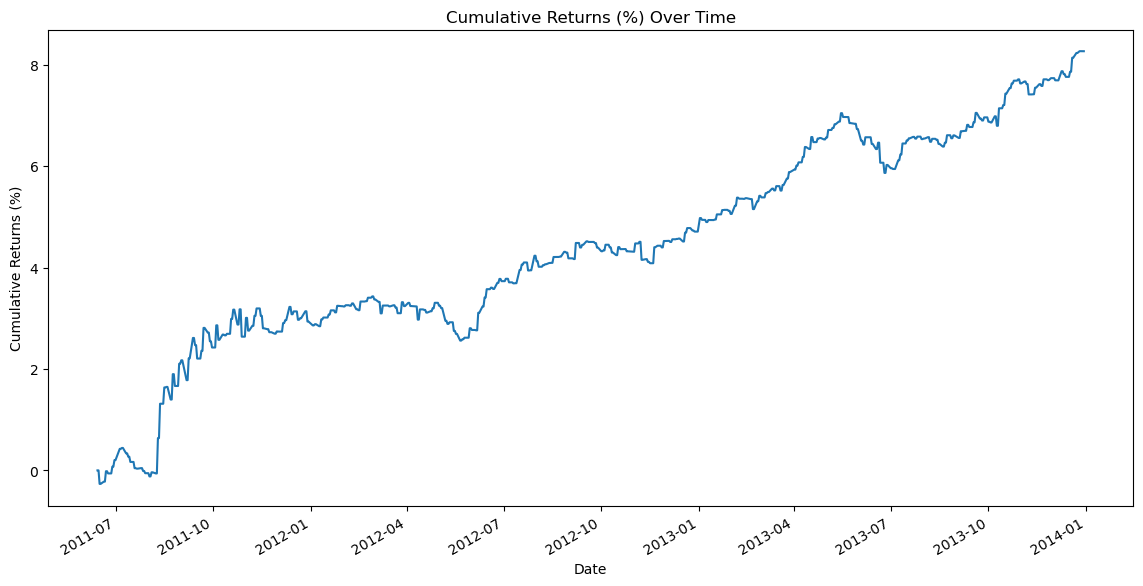

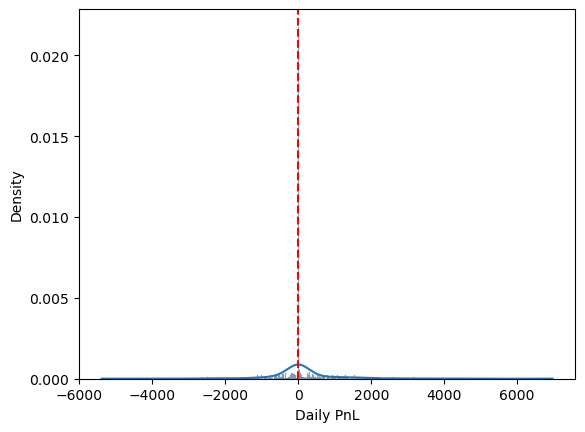

Max Drawdown (%) = 1%


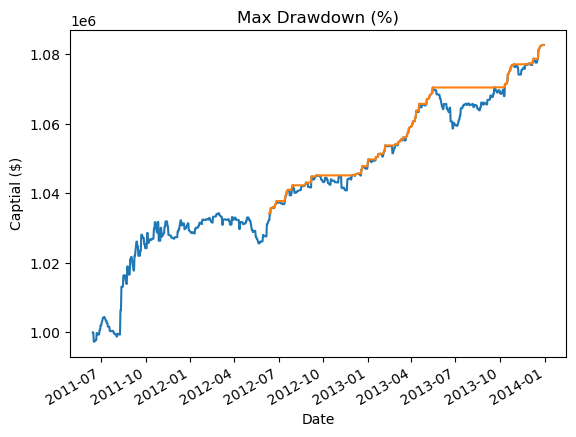

,Drawdown Period (Days),Max Drawdown (%),Start,End
0,126.0,1.100602,2013-05-16,2013-09-19
1,72.0,0.413354,2012-09-18,2012-11-29
2,27.0,0.208374,2012-07-31,2012-08-27
3,23.0,0.275663,2013-10-30,2013-11-22
4,21.0,0.237697,2013-09-20,2013-10-11


Max Drawdown Period = 126.0 days


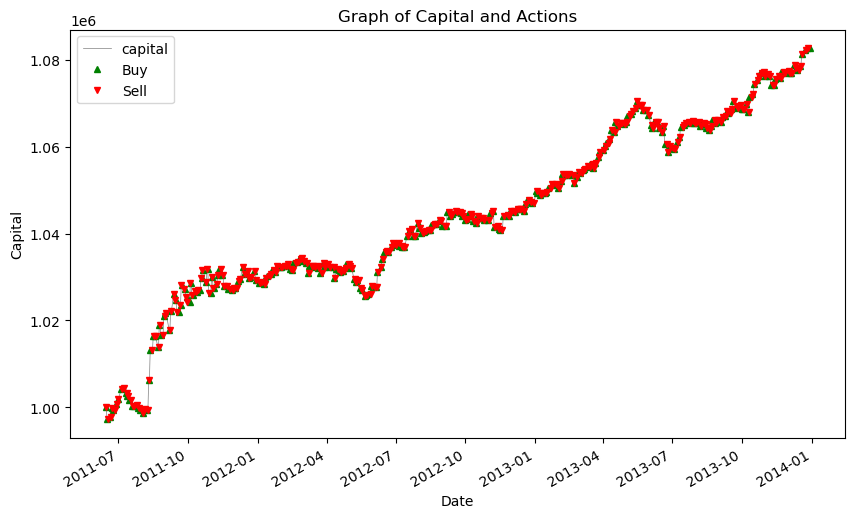

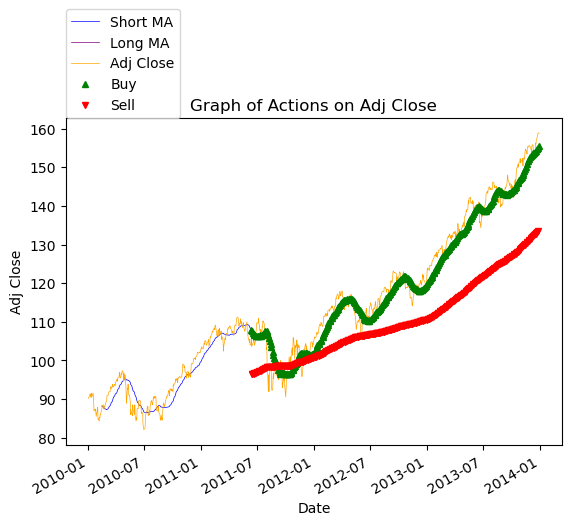

In [5]:
short_window = 30
long_window = 365
capital = 1000000
delta = 0.02  # 0.02 = 2%
capital_per_trade = 0.15 # (e.g.) 0.1 = 10%

df = pd.read_csv('SPY (2003-01 - 2021-11).csv')
df = df[['Date','Adj Close']]
df = df[(df['Date'] >= '2010-01-04') & (df['Date'] <= '2013-12-30')]
df['short_ma'] = df['Adj Close'].rolling(window=short_window).mean()
df['long_ma'] = df['Adj Close'].rolling(window=long_window).mean()

backtest(df, short_window, long_window, delta, capital, capital_per_trade)

<a id='out-sample'></a>
# Out-sample testing
- The out-of-sample data is data before 20I will separately backtest the linear regression model on data before 2010-01-04, and on data after 2010-01-04, and combine certain metrics such as net profit.
- It is not appropriate to join the 2 different periods of testing data together, and backtest it in one-go. This is because Adj Close will jump sharply from 90.2 to 183 as a result. By backtesting the two periods separately and combine their net profit, it is akin to trading on the strategy during the first period, stop trading from 2010-2014, and resume trading thereafter
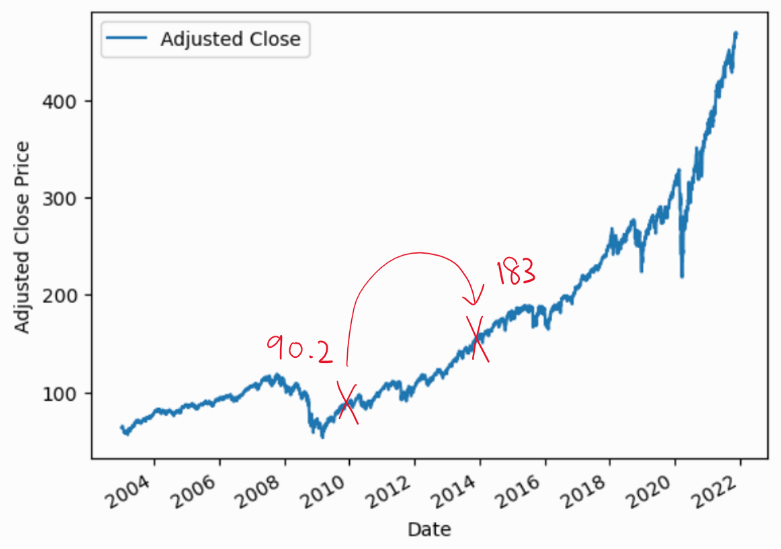

Net Profit = 10%
CAGR = 1%
Average daily profit = $619
Total number of trades per year =  199.9
Win rate = 27%
Mean of Daily Pnl = $1559
Standard Deviation of Daily Pnl = 2714
Average Positive Pnl($) =  141
Average Negative Pnl($) =  -140
Payout Ratio =  1
Sharpe Ratio = 1%
Sortino Ratio = 0%
Beta =  -0.3


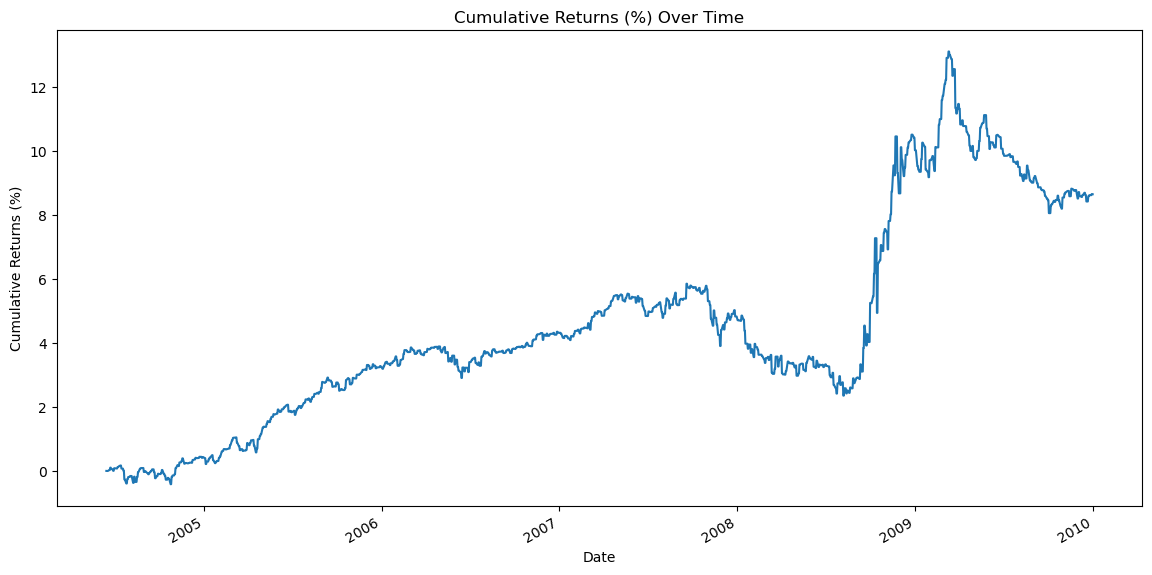

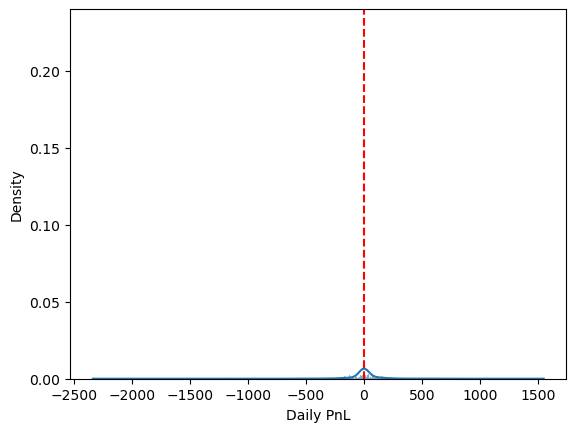

Max Drawdown (%) = 4%


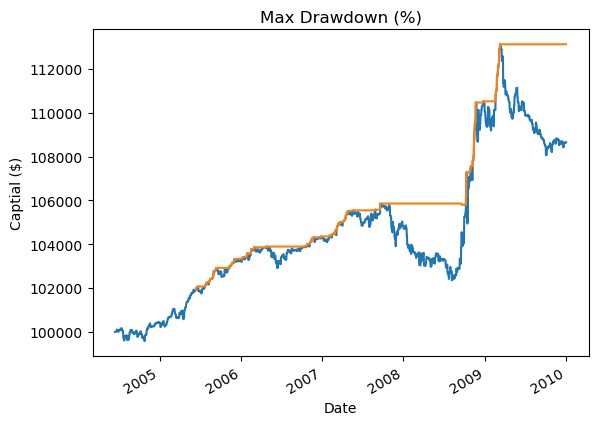

,Drawdown Period (Days),Max Drawdown (%),Start,End
0,384.0,3.307001,2007-09-20,2008-10-08
1,168.0,0.948498,2006-05-01,2006-10-16
2,97.0,0.717391,2007-05-22,2007-08-27
3,59.0,0.399733,2005-09-13,2005-11-11
4,54.0,1.204815,2008-12-26,2009-02-18


Max Drawdown Period = 384.0 days


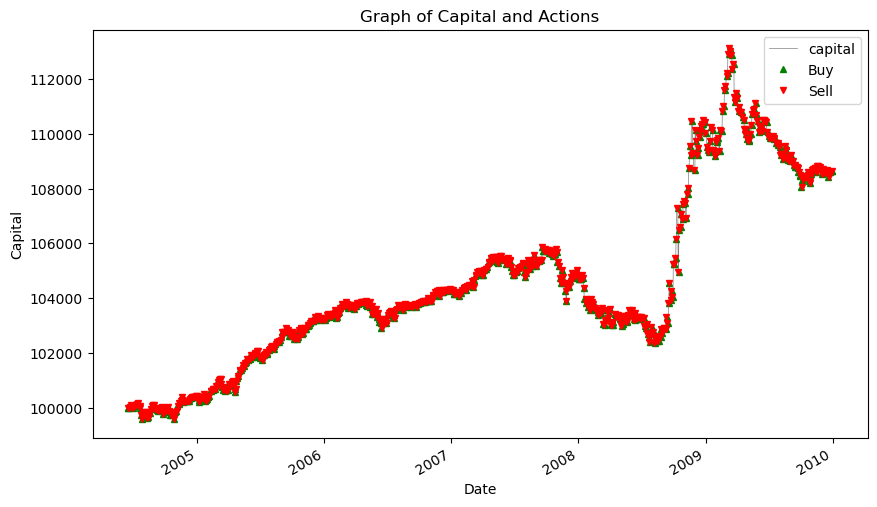

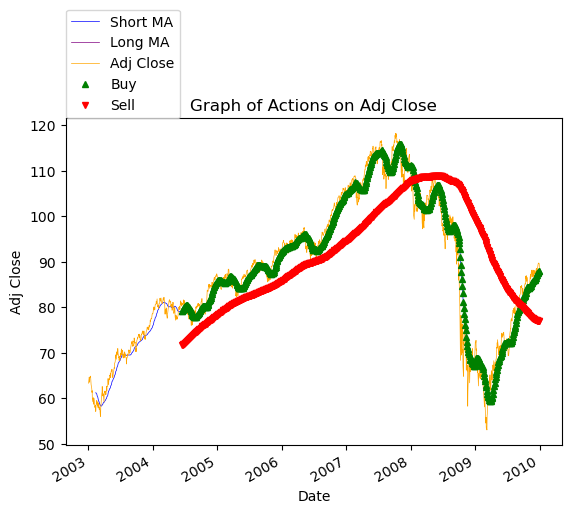

In [120]:
short_window = 30
long_window = 365
delta = 0.02  
capital = 1000000
capital_per_trade = 0.15 

df = pd.read_csv('SPY (2003-01 - 2021-11).csv')
df = df[['Date','Adj Close']]
df = df[df['Date'] < '2010-01-04']
df['short_ma'] = df['Adj Close'].rolling(window=short_window).mean()
df['long_ma'] = df['Adj Close'].rolling(window=long_window).mean()

backtest(df, short_window, long_window, delta, capital, capital_per_trade)

In [128]:
100000*1.1 # as net profit is 10%

110000.00000000001

<font color='red'> First period of out-of-sample backtesting gives a net profit of 10%, hence capital on 2010-01-4 is $110000 (as net profit is 10%). Assume this is the inital capital for the second out-of-sample period

Net Profit = -10%
CAGR = -1%
Average daily profit = $-81
Total number of trades per year =  205.8
Win rate = 28%
Mean of Daily Pnl = $-203
Standard Deviation of Daily Pnl = 2003
Average Positive Pnl($) =  96
Average Negative Pnl($) =  -122
Payout Ratio =  1
Sharpe Ratio = 0%
Sortino Ratio = 0%
Beta =  0.37


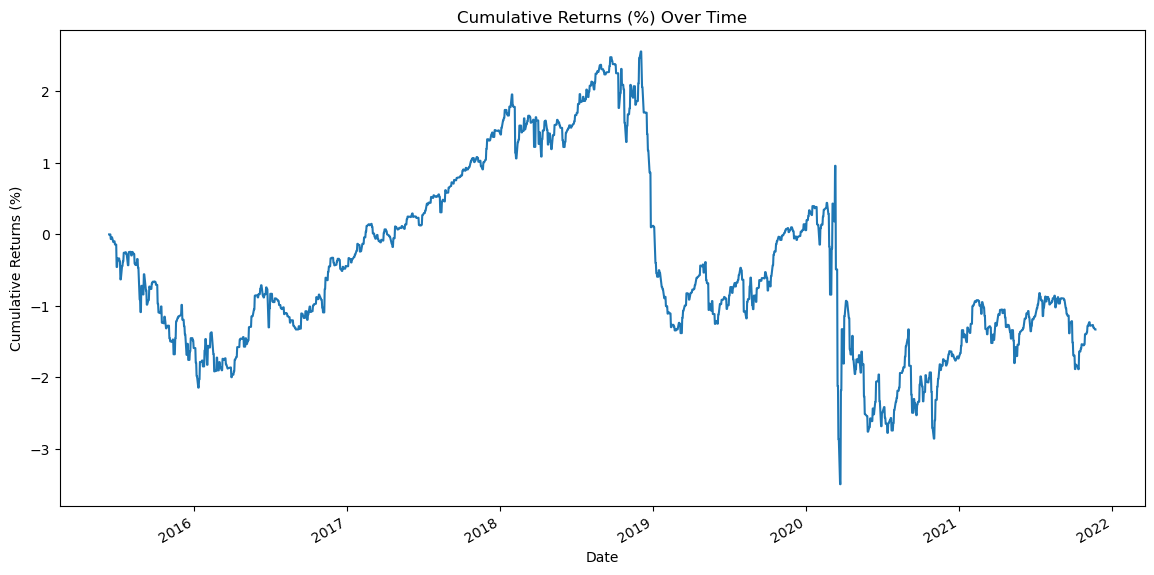

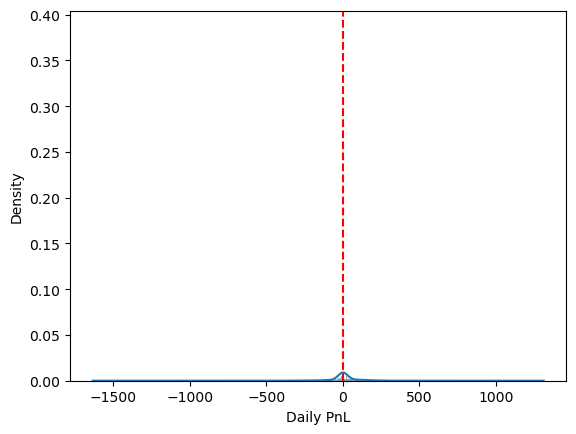

Max Drawdown (%) = 4%


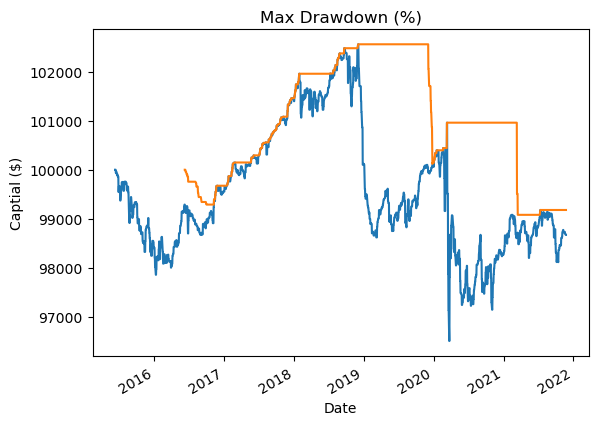

,Drawdown Period (Days),Max Drawdown (%),Start,End
0,487.0,4.411185,2020-03-12,2021-07-12
1,388.0,3.841064,2018-12-04,2019-12-27
2,161.0,0.877844,2018-01-30,2018-07-10
3,84.0,0.322677,2017-02-28,2017-05-23
4,70.0,1.156883,2018-09-24,2018-12-03


Max Drawdown Period = 487.0 days


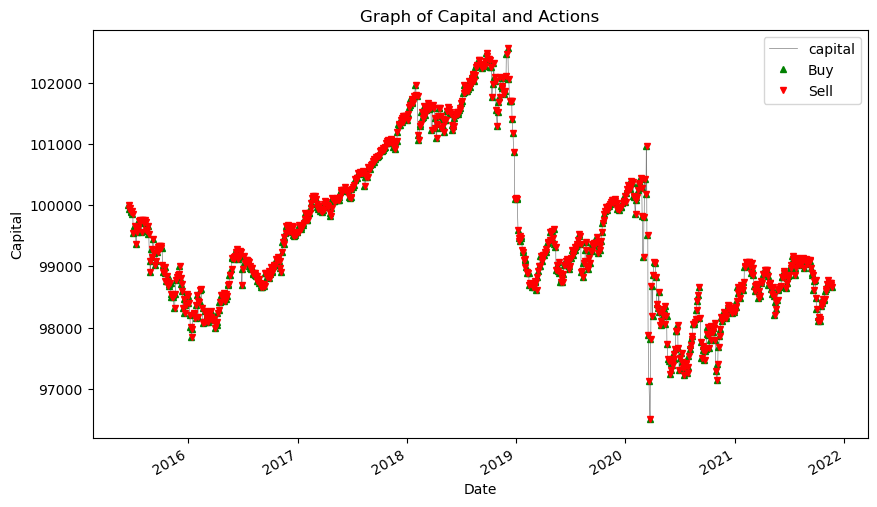

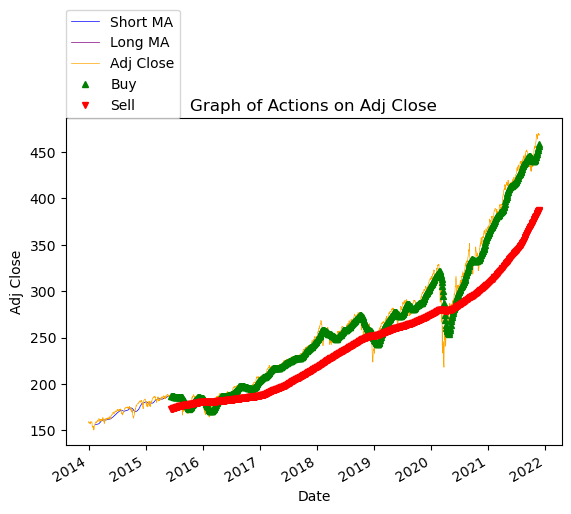

In [124]:
short_window = 30
long_window = 365
delta = 0.02  
capital = 110000
capital_per_trade = 0.15

df = pd.read_csv('SPY (2003-01 - 2021-11).csv')
df = df[['Date','Adj Close']]
df = df[(df['Date'] > '2013-12-30') ]

df['short_ma'] = df['Adj Close'].rolling(window=short_window).mean()
df['long_ma'] = df['Adj Close'].rolling(window=long_window).mean()

backtest(df, short_window, long_window, delta, capital_per_trade)

In [125]:
110000*0.9 # as net profit is -10%

99000.0

<font color='red'> 16-years of out-of-sample testing gives a final capital of $99000. This means that while in-sample testing gave a net profit of 8% over 4 years, out-of-sample testing give a net loss of 1%.

# Backtesting performance of strategy over entire data period

Net Profit = 6%
CAGR = 0%
Average daily profit = $142
Total number of trades per year =  232.7
Win rate = 27%
Mean of Daily Pnl = $358
Standard Deviation of Daily Pnl = 2262
Average Positive Pnl($) =  115
Average Negative Pnl($) =  -134
Payout Ratio =  1
Sharpe Ratio = 0%
Sortino Ratio = 0%
Beta =  0.06


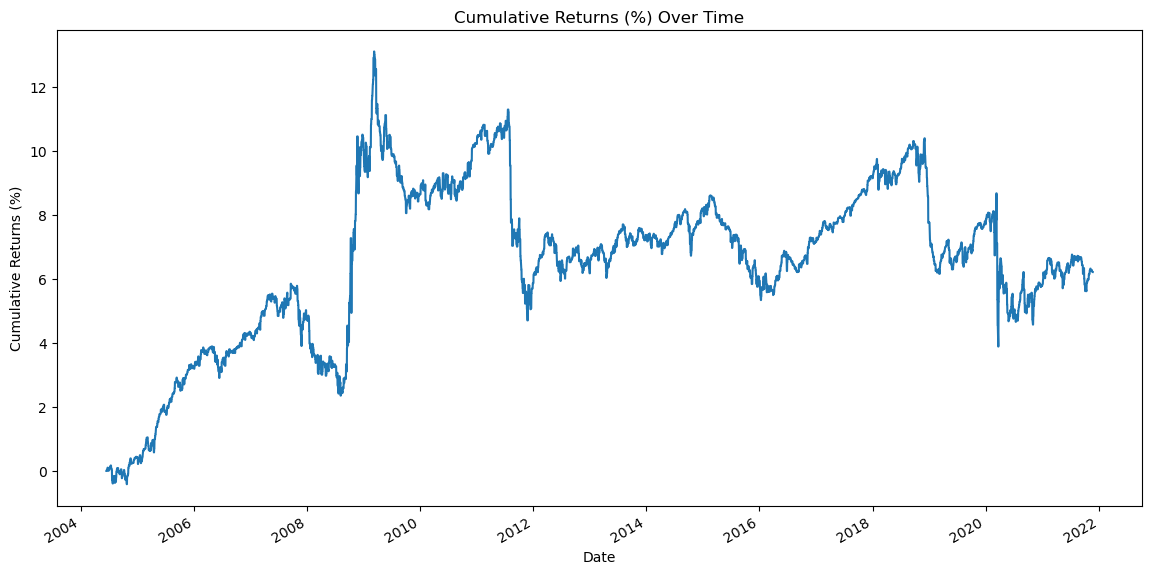

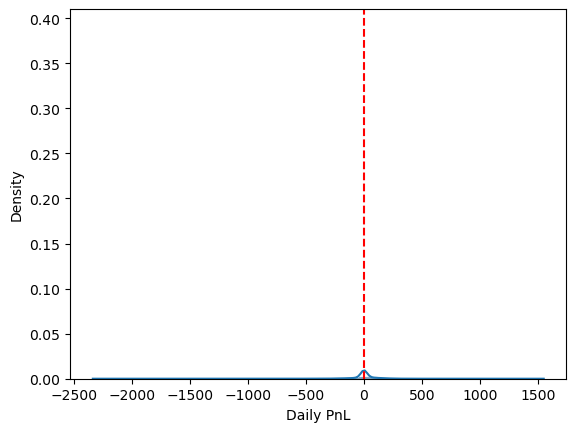

Max Drawdown (%) = 6%


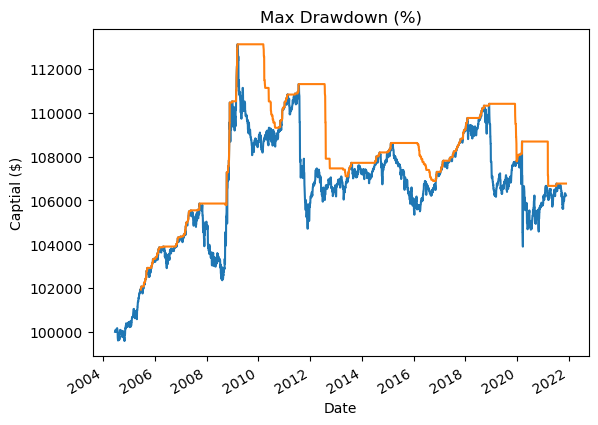

,Drawdown Period (Days),Max Drawdown (%),Start,End
0,690.0,5.926062,2011-07-25,2013-06-14
1,630.0,3.014021,2015-02-19,2016-11-10
2,586.0,4.470576,2009-03-11,2010-10-18
3,487.0,4.411185,2020-03-12,2021-07-12
4,388.0,3.841064,2018-12-04,2019-12-27


Max Drawdown Period = 690.0 days


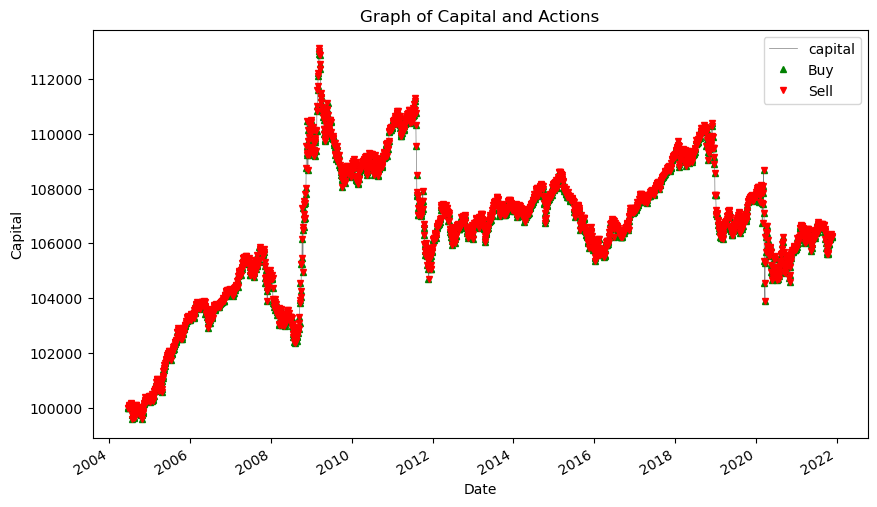

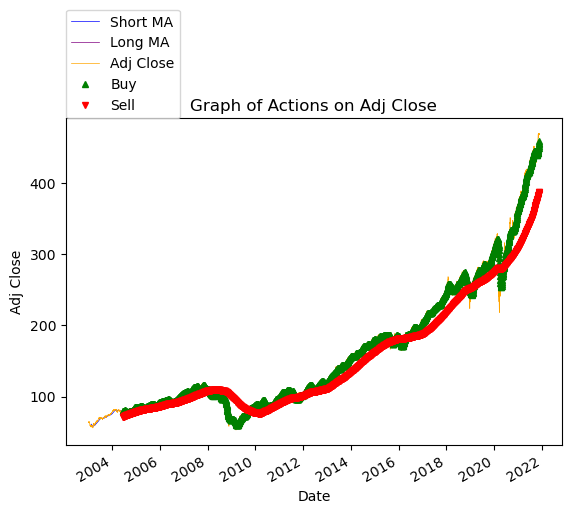

In [127]:
short_window = 30
long_window = 365
delta = 0.02  
capital = 100000
capital_per_trade = 0.15 

df = pd.read_csv('SPY (2003-01 - 2021-11).csv')
df = df[['Date','Adj Close']]

df['short_ma'] = df['Adj Close'].rolling(window=short_window).mean()
df['long_ma'] = df['Adj Close'].rolling(window=long_window).mean()

# Initialize positions and PnL
df['position'] = 0  # 1 = long, -1 = short, 0 = no position

df=df.reset_index(drop=True)

for i in range(long_window-1, len(df)):
    if df.loc[i-1, 'position'] == 0:
        if df.loc[i, 'short_ma'] > df.loc[i, 'long_ma']:
            df.loc[i, 'position'] = 1
        elif df.loc[i, 'short_ma'] < df.loc[i, 'long_ma']:
            df.loc[i, 'position'] = -1
    
    elif df.loc[i-1, 'position'] == 1:

        if df.loc[i, 'Adj Close'] < df.loc[i-1, 'Adj Close'] * (1 - delta) or \
           df.loc[i, 'short_ma'] < df.loc[i, 'long_ma']:
            df.loc[i, 'position'] = 0
    
    elif df.loc[i-1, 'position'] == -1:
        
        if df.loc[i, 'Adj Close'] > df.loc[i-1, 'Adj Close'] * (1 + delta) or \
           df.loc[i, 'short_ma'] > df.loc[i, 'long_ma']:
            df.loc[i, 'position'] = 0

df.loc[long_window-2, 'position'] = 0.0
position_diff = df['position'].diff()
df['action'] = np.where(position_diff > 0, 1, np.where(position_diff < 0, -1, 0)) # When position_diff > 0, assign 1; when position_diff < 0, assign -1; otherwise, assign 0

df['position'] = df['position'].shift() 
# long today close, first pnl($)  = (tmr close - today close) * notional ($), hence shift '1' position from today index to tmr index
# (Eg) the way to look at the following data is that, during the trading hours of 2003-02-14, I have a short position
#           Date      dj Close    short_ma     long_ma    position   close_change_pct  
# 30    2003-02-14   58.467773   58.389266   61.064491      -1.0     0.021858

df.loc[long_window-1, 'position'] = 0.0
df['close_change_pct'] = df['Adj Close'].pct_change()

df['capital'] = np.nan # df['capital'] shows the capital at close at each datetime inde
df.loc[long_window-1,'capital'] = capital

for i in range(long_window-1, len(df)):
    dollar_pnl = df.loc[i,'position'] * df.loc[i,'close_change_pct'] * df.loc[i, 'capital'] * capital_per_trade
    df.loc[i+1, 'capital'] = df.loc[i, 'capital'] + dollar_pnl
    
df['daily_pnl'] = df['capital'].diff()

# Round the 'daily_pnl' column to 5 significant figures
df['daily_pnl'] = df['daily_pnl'].round(5)

# Convert the 'Date' column to datetime if it's not already in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Format the 'Date' column to 'yyyy-mm-dd'
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

df2 = df[['Date','daily_pnl']].dropna()

# Output the DataFrame to a CSV file
df2.to_csv('Daily Pnl.csv', index=False)

df['cum_ret'] = ((df['capital'] - capital) / capital) *100

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True) # Set 'Date' as the index of the DataFrame

df = performance_metrics(df)


<a id='benchmark'></a>
# (Benchmark) Buy & Hold Strategy

In [47]:
df = pd.read_csv('SPY (2003-01 - 2021-11).csv')
df = df[(df['Date'] >= '2010-01-04') & (df['Date'] <= '2013-12-30') ]
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
net_profit = round(((df['Adj Close'][-1] / df['Adj Close'][0]) - 1) * 100)
print('Net profit for a passive buy& hold strategy during the in-sample data period = ', net_profit, '%')

Net profit for a passive buy& hold strategy during the in-sample data period =  76 %


<a id='strategy1'></a>
# Strategy 1

Net Profit = 1%
CAGR = 0%
Average daily profit = $53
Total number of trades per year =  244.5
Win rate = 26%
Mean of Daily Pnl = $134
Standard Deviation of Daily Pnl = 248
Average Positive Pnl($) =  16
Average Negative Pnl($) =  -15
Payout Ratio =  1
Sharpe Ratio = 1%
Sortino Ratio = 0%
Beta =  0.01


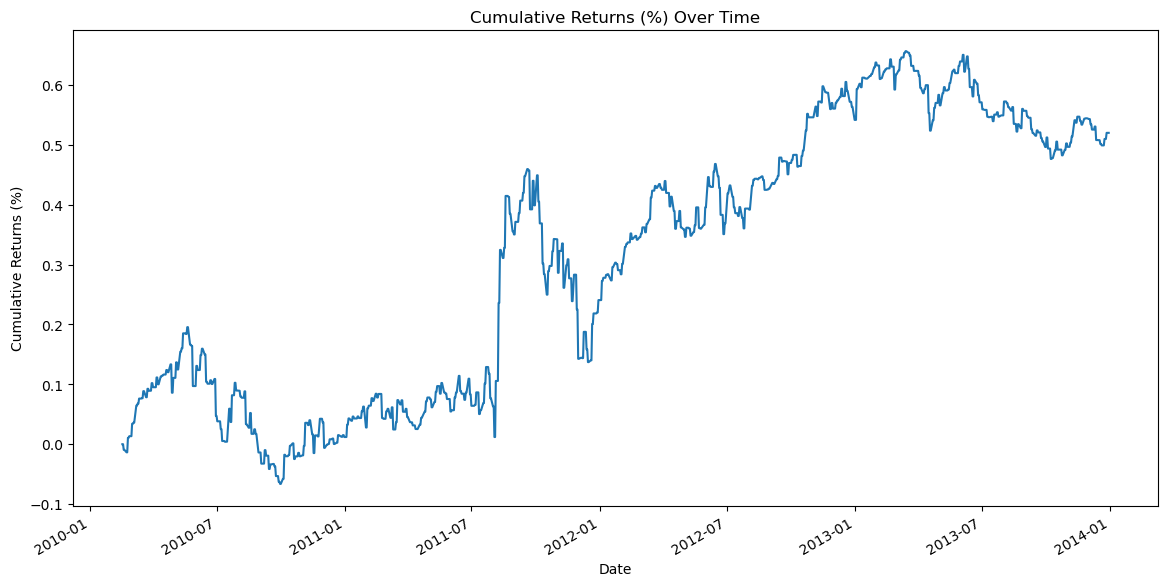

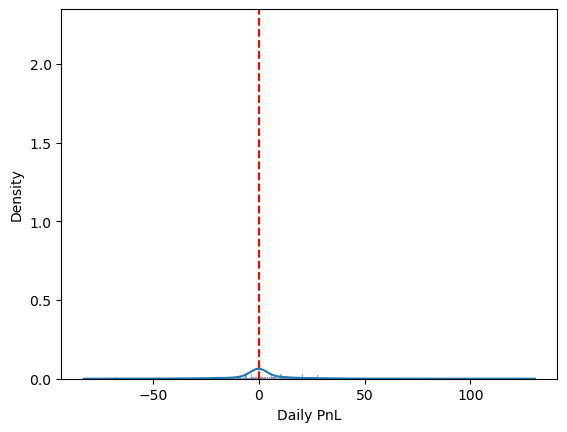

Max Drawdown (%) = 0%


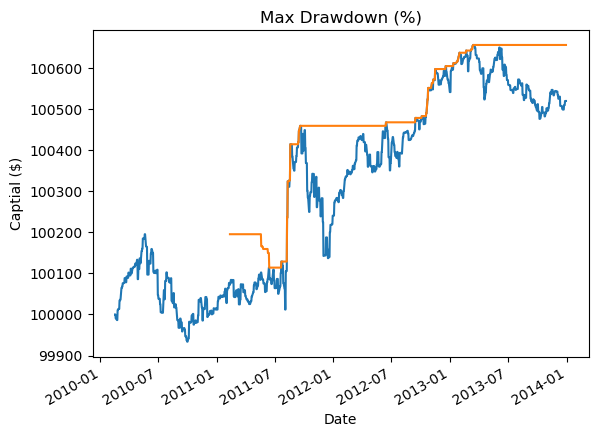

,Drawdown Period (Days),Max Drawdown (%),Start,End
0,268.0,0.321015,2011-09-20,2012-06-14
1,91.0,0.116697,2012-06-15,2012-09-14
2,38.0,0.063735,2011-06-14,2011-07-22
3,32.0,0.037985,2012-11-16,2012-12-18
4,23.0,0.063044,2012-12-19,2013-01-11


Max Drawdown Period = 268.0 days


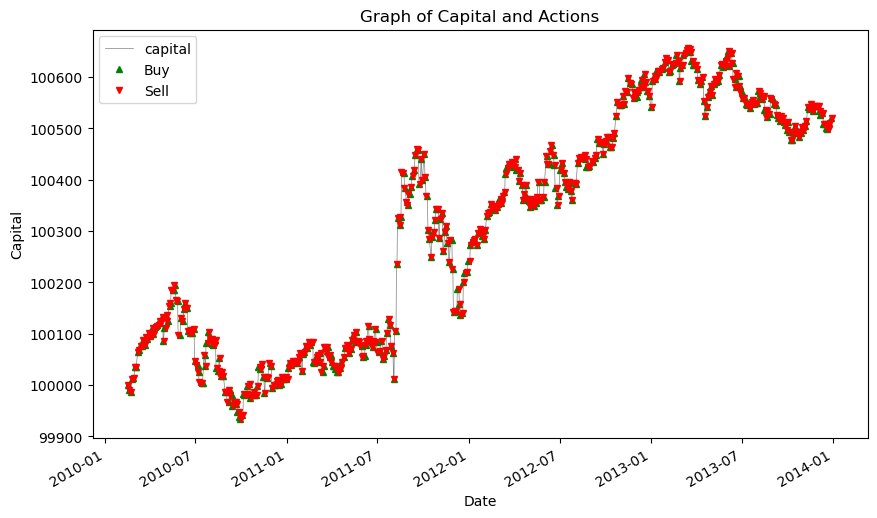

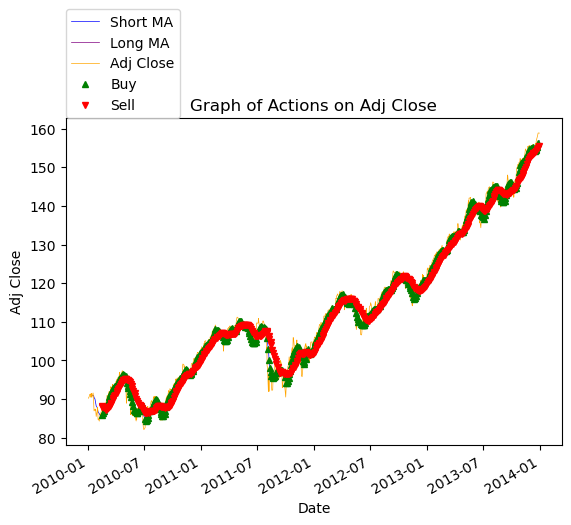

In [7]:
short_window = 10
long_window = 30
delta = 0.02  
capital = 100000
capital_per_trade = 0.02 

df = pd.read_csv('SPY (2003-01 - 2021-11).csv')
df = df[['Date','Adj Close']]
df = df[(df['Date'] >= '2010-01-04') & (df['Date'] <= '2013-12-30') ]
df['short_ma'] = df['Adj Close'].rolling(window=short_window).mean()
df['long_ma'] = df['Adj Close'].rolling(window=long_window).mean()

backtest(df, short_window, long_window, delta, capital, capital_per_trade)

<a id='correctness'></a>
# Cross check correctness of my code against the "backtrader" Python backtesting library
- (Note) strategy for the backtesting library **is different** from the strategy in this case, but it can still act as a gauge for correctness of my code to some extent

### Strategy for the backtesting library
- 2 MA of 10-days and 30-days
- "order" attribute to track outstanding orders
- Strategy Logic
    - **Entering a Position**
    - If there is no current position, and the 10-day MA is greater than the 30-day MA, a buy order is placed to enter a long position.
    - Conversely, if the 10-day MA is less than the 30-day MA, a sell order is placed to initiate a short position.
    - **Exiting a Position**
    - For an open long position, if the closing price falls more than the stop loss percentage (2% from the entry price) below the entry price, or if a bearish crossover occurs (10-day MA falls below the 30-day MA), the position is closed.
    - Similarly, for an open short position, if the closing price rises more than the stop loss percentage above the entry price, or if a bullish crossover occurs (10-day MA rises above the 30-day MA), the position is closed.
- Cerebro Engine:
    - The Cerebro engine, which manages the backtesting, is configured with the strategy, data feed, initial cash ($100,000), and commission rate (0%).
- Strategy Execution:
    - The strategy is executed with a call to cerebro.run().
    - It prints the portfolio value at the start and end of the execution.
        

In [ ]:
# Load data from CSV
df = pd.read_csv('SPY (2003-01 - 2021-11).csv')
df = df[['Date', 'Adj Close']]
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.loc['2010-01-04':'2013-12-31']

# Create a Strategy
class MovingAverageCrossStrategy(bt.Strategy):
    params = (
        ('short_window', 10),
        ('long_window', 30),
        ('stop_loss_percent', 0.02),
    )

    def __init__(self):
        self.sma_short = bt.indicators.SMA(self.datas[0], period=self.params.short_window)
        self.sma_long = bt.indicators.SMA(self.datas[0], period=self.params.long_window)
        self.order = None

    def log(self, txt, dt=None):
        ''' Logging function for this strategy '''
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, {order.executed.price}')
            elif order.issell():
                self.log(f'SELL EXECUTED, {order.executed.price}')
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
        self.order = None

    def next(self):
        if self.order:
            return
        if not self.position:
            if self.sma_short[0] > self.sma_long[0]:
                self.log('BUY CREATE, %.2f' % self.datas[0].close[0])
                self.order = self.buy()
            elif self.sma_short[0] < self.sma_long[0]:
                self.log('SELL CREATE, %.2f' % self.datas[0].close[0])
                self.order = self.sell()
        else:
            if self.position.size > 0:
                if (self.datas[0].close[0] < self.position.price * (1.0 - self.params.stop_loss_percent)) or (self.sma_short[0] < self.sma_long[0]):
                    self.log('CLOSE LONG, %.2f' % self.datas[0].close[0])
                    self.order = self.close()
            elif self.position.size < 0:
                if (self.datas[0].close[0] > self.position.price * (1.0 + self.params.stop_loss_percent)) or (self.sma_short[0] > self.sma_long[0]):
                    self.log('CLOSE SHORT, %.2f' % self.datas[0].close[0])
                    self.order = self.close()

# Create a cerebro entity
cerebro = bt.Cerebro()

# Add the strategy
cerebro.addstrategy(MovingAverageCrossStrategy)

# Create a Data Feed
class PandasData(bt.feeds.PandasData):
    params = (
        ('datetime', None),
        ('open', 'Adj Close'),
        ('high', 'Adj Close'),
        ('low', 'Adj Close'),
        ('close', 'Adj Close'),
        ('volume', None),
        ('openinterest', None),
    )

# Pass it to the backtrader datafeed and add it to the cerebro
data = PandasData(dataname=df)
cerebro.adddata(data)

# Set the initial cash
cerebro.broker.set_cash(100000.0)

# Set the commission
cerebro.broker.setcommission(commission=0)

# Print the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run the strategy
cerebro.run()

# Print the final results
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

## Observations
<font color='red'> Cumulative return of the backtesting library is not too different from my code. Hence the cross check does not suggest that my code is significantly incorrect </font>

# Cross check correctness of my code against "etfscreen.com" (an online backtesting platform)
- https://www.etfscreen.com/moving-average-backtest.php?temp=WlYloc
- Strategy tested is a simple moving average crossover strategy, with periods as 10 and 30 days, with no stop loss
- CAGR here is 6.28% which is much higher that the CAGR of my backtesting.
- The difference in performance is because
    - etfscreen.com does not allow for stop-loss
    - backtesting period for my code is from 2010-01-04 to 2013-12-30, but it is around 2019-2024. (etfscreen.com does not allow user to backtest specifically for 2010-01-04 to 2013-12-30)
- <font color='red'> It turns out that etfscreen.com is not a good source to cross check correctness of my code. </font> When I use etfscreen.com to backtest for the last 10 years (2014-2024), the CAGR is 6.44%. This does give me a rough figure in mind when I do out-of-sample testing using a similar period. Hopefully, a MA strategy involving more exotic MA and a stop loss mechanism can outperform a vanilla SMA strategy
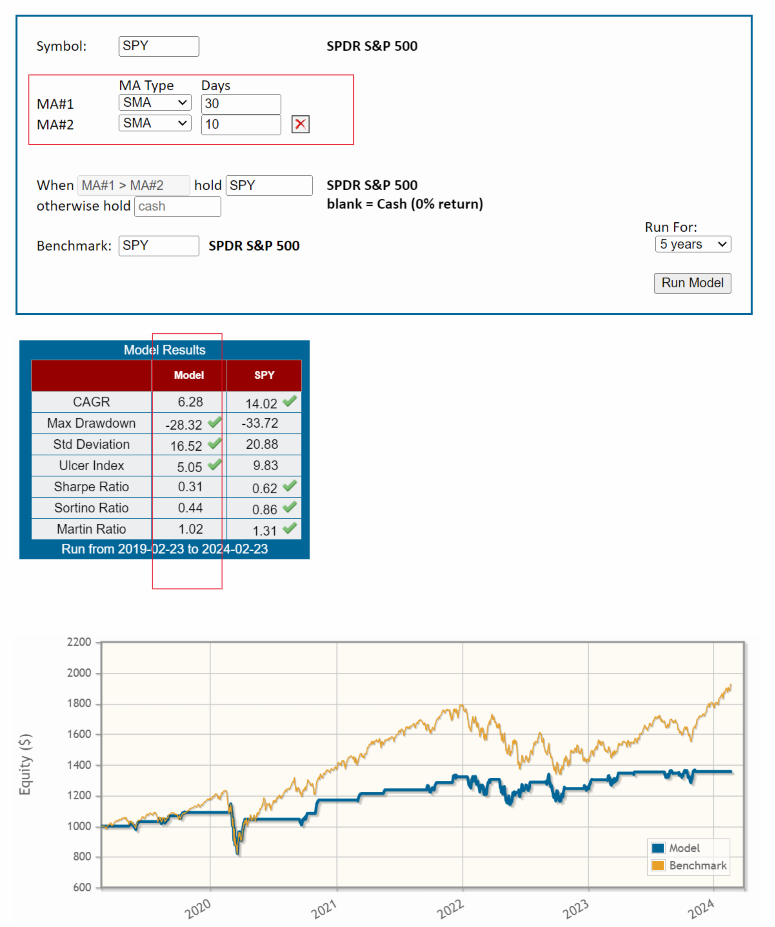

<a id='strategy2'></a>
# Strategy 2
- Strategy 2 consider some simple variations of strategy 1 with different MA periods, delta and capital per trade

In [ ]:
def strategy2(strategy_num, short_window, long_window, delta, capital_per_trade):
    res = [strategy_num, short_window, long_window, delta, capital_per_trade]
    
    capital = 100000
    df = pd.read_csv('SPY (2003-01 - 2021-11).csv')
    df = df[['Date','Adj Close']]
    df = df[(df['Date'] >= '2010-01-04') & (df['Date'] <= '2013-12-30') ]

    df['short_ma'] = df['Adj Close'].rolling(window=short_window).mean()
    df['long_ma'] = df['Adj Close'].rolling(window=long_window).mean()

    df['position'] = 0  # 1 = long, -1 = short, 0 = no position

    df=df.reset_index(drop=True)

    for i in range(long_window-1, len(df)):
        if df.loc[i-1, 'position'] == 0:
            if df.loc[i, 'short_ma'] > df.loc[i, 'long_ma']:
                df.loc[i, 'position'] = 1
            elif df.loc[i, 'short_ma'] < df.loc[i, 'long_ma']:
                df.loc[i, 'position'] = -1

        elif df.loc[i-1, 'position'] == 1:

            if df.loc[i, 'Adj Close'] < df.loc[i-1, 'Adj Close'] * (1 - delta) or \
               df.loc[i, 'short_ma'] < df.loc[i, 'long_ma']:
                df.loc[i, 'position'] = 0

        elif df.loc[i-1, 'position'] == -1:

            if df.loc[i, 'Adj Close'] > df.loc[i-1, 'Adj Close'] * (1 + delta) or \
               df.loc[i, 'short_ma'] > df.loc[i, 'long_ma']:
                df.loc[i, 'position'] = 0

    df.loc[long_window-2, 'position'] = 0.0
    position_diff = df['position'].diff()
    df['action'] = np.where(position_diff > 0, 1, np.where(position_diff < 0, -1, 0)) # When position_diff > 0, assign 1; when position_diff < 0, assign -1; otherwise, assign 0

    df['position'] = df['position'].shift() 

    df.loc[long_window-1, 'position'] = 0.0
    df['close_change_pct'] = df['Adj Close'].pct_change()

    df['capital'] = np.nan # df['capital'] shows the capital at close at each datetime inde
    df.loc[long_window-1,'capital'] = capital

    for i in range(long_window-1, len(df)):
        dollar_pnl = df.loc[i,'position'] * df.loc[i,'close_change_pct'] * df.loc[i, 'capital'] * capital_per_trade
        df.loc[i+1, 'capital'] = df.loc[i, 'capital'] + dollar_pnl

    df['daily_pnl'] = df['capital'].diff()
    df['cum_ret'] = ((df['capital'] - capital) / capital) *100

    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True) # Set 'Date' as the index of the DataFrame    

In [ ]:
strategy_num = 1

short_windows = [10, 30, 60, 90, 120, 180,]
long_windows = [30, 60, 90, 120, 180, 365]
deltas = [0.02, 0.03, 0.05, 0.075, 0.1, 0.125, 0.15]
capital_per_trades = [0.02, 0.05, 0.075, 0.1, 0.125, 0.15]

for params in itertools.product(short_windows, long_windows, deltas, capital_per_trades):
    short_window, long_window, delta, capital_per_trade = params
    if long_window > short_window:
        strategy2(strategy_num, short_window, long_window, delta, capital_per_trade)
        strategy_num+=1
    else:
        continue

## Observations
- Highest net profit of 8% happens when short window is 30 days and long window is 365 days
- In view of such disappointing performances, a passive buy and hold strategy for SPY is a challenge to beat
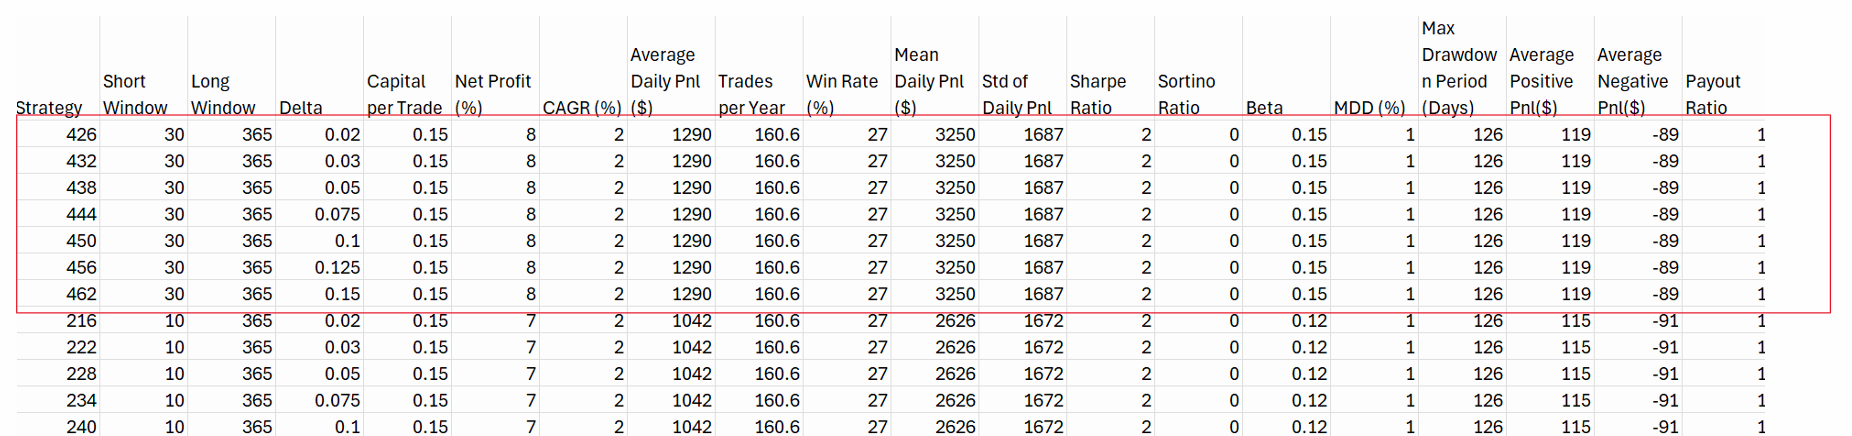

## Further analyse this set of parameters
- Short Window = 30 days
- Long Window = 365 days
- Delta = 2%
- Capital per Trade = 15%

Net Profit = 8%
CAGR = 2%
Average daily profit = $1290
Total number of trades per year =  160.6
Win rate = 27%
Mean of Daily Pnl = $3250
Standard Deviation of Daily Pnl = 1687
Average Positive Pnl($) =  119
Average Negative Pnl($) =  -89
Payout Ratio =  1
Sharpe Ratio = 2%
Sortino Ratio = 0%
Beta =  0.15


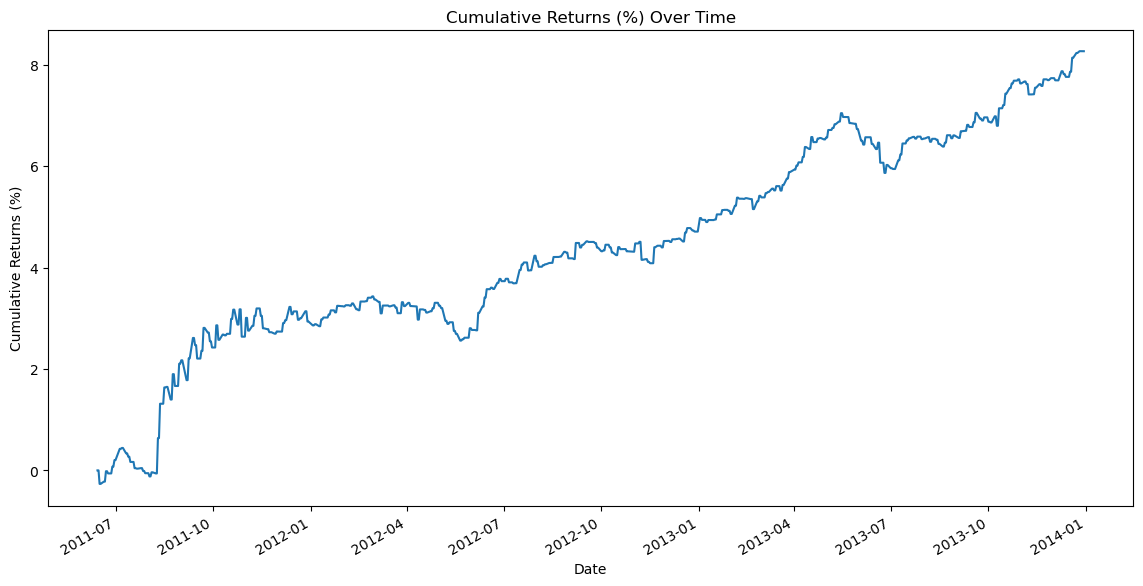

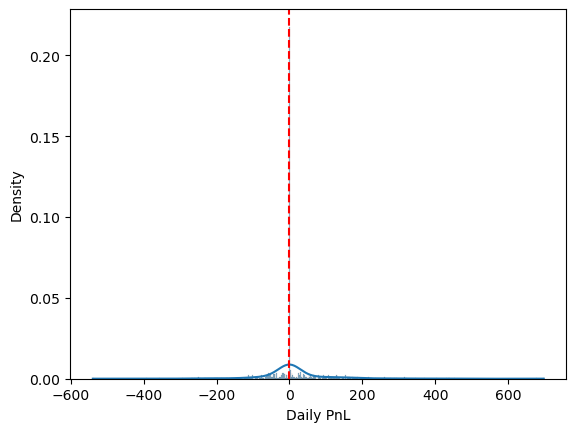

Max Drawdown (%) = 1%


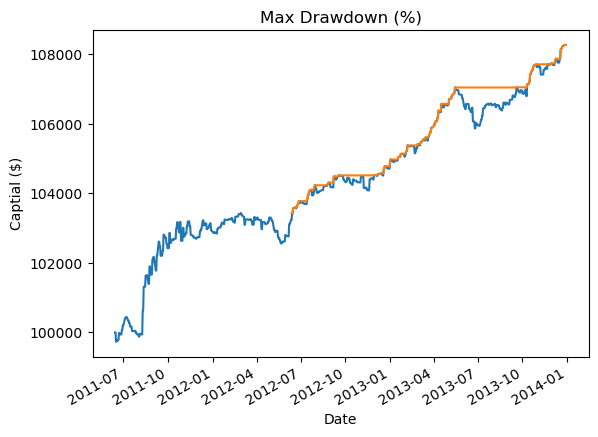

,Drawdown Period (Days),Max Drawdown (%),Start,End
0,126.0,1.100602,2013-05-16,2013-09-19
1,72.0,0.413354,2012-09-18,2012-11-29
2,27.0,0.208374,2012-07-31,2012-08-27
3,23.0,0.275663,2013-10-30,2013-11-22
4,21.0,0.237697,2013-09-20,2013-10-11


Max Drawdown Period = 126.0 days


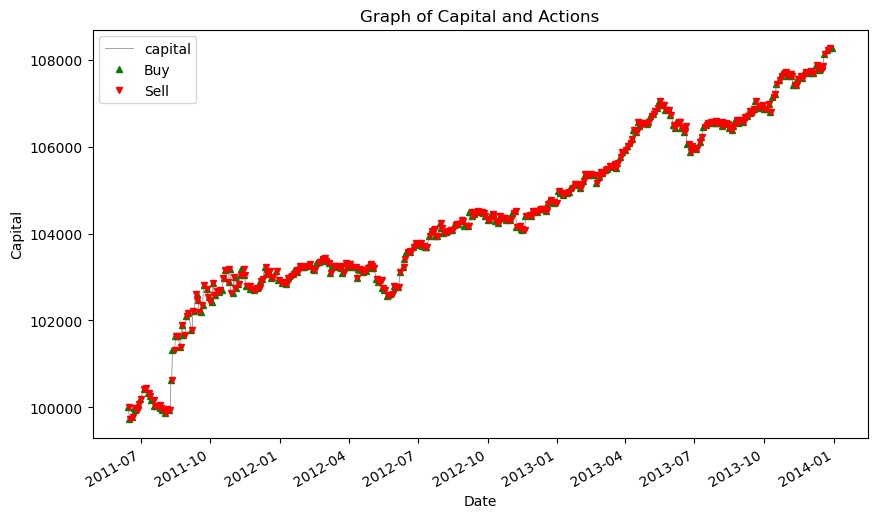

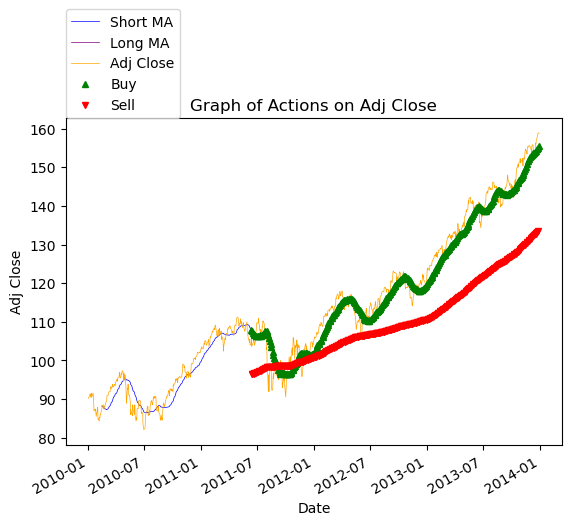

In [156]:
short_window = 30
long_window = 365
delta = 0.02  
capital = 100000
capital_per_trade = 0.15 

df = pd.read_csv('SPY (2003-01 - 2021-11).csv')
df = df[['Date','Adj Close']]
df = df[(df['Date'] >= '2010-01-04') & (df['Date'] <= '2013-12-30') ]

df['short_ma'] = df['Adj Close'].rolling(window=short_window).mean()
df['long_ma'] = df['Adj Close'].rolling(window=long_window).mean()

backtest(df, short_window, long_window, delta, capital_per_trade)

## Observations
- The model seems to be overfitted. The SPY was appreciating most of the times during this period, and the short MA is almost always higher than the long MA, as the SPY continue to hit new highs. This strategy is always entering into a long position, and will close the position when the stop loss level is hit. 

<a id='strategy3'></a>
# Strategy 3
- Similar to Strategy 1 except this strategy uses Exponential Moving Average (EMA)

### Exponential Moving Average (EMA)


- **"span"** (number of periods for the exponential window, related to alpha as alpha=2/(span+1)):
    - (Note) span, alpha, com and halflife are 4 ways to specify decay factor, user can only adjust one of them. In this 
    - Range: 0 to +inf
    - Low: Greater than 30 (smoother)
    - Medium: Between 15 to 30
    - High: Less than 15 (more responsive)

- **"adjust"** (whether to divide by the sum of the weights):
    - Typically True or False (True uses the standard exponentially weighted formula, False might be preferred for financial time series)
    - **"False" is more common for financial time series** like SPY because it starts the EMA calculation immediately and is considered to give a more "true" representation of the EMA for most financial applications where the emphasis is on the more recent data. When adjust=True, the weights are normalized by the sum of the weights, which makes the EMA at each point a true weighted average of all prior points, giving more weight to older data than the recursive method.
    - 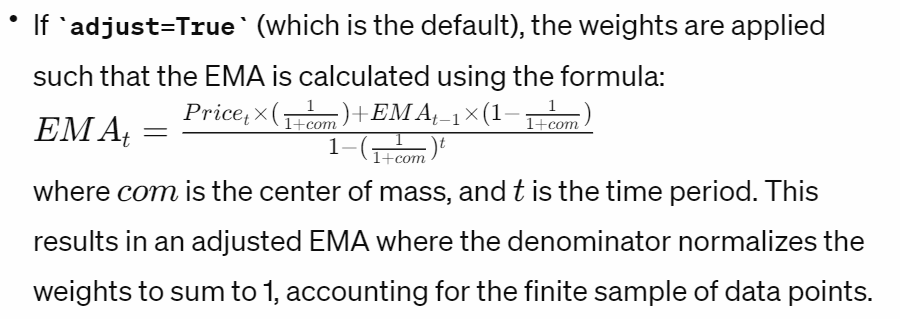

- **"ignore_na"** (whether to ignore missing values):
    - True or False (True to ignore NA values in calculations)

- **"min_periods"** (minimum number of observations in window required to have a value):
    - Low: 0 or 1 (less strict, allows EMA calculation to start with as little as 1 non-NA value)
    - Medium: About half of span or halflife period
    - High: Equal to span or halflife (strict, requires a full window of non-NA values to calculate)

- **"times"** (Optional time periods, can be DatetimeIndex, TimedeltaIndex, or array-like):
    - Used for irregular time series. The impact varies significantly depending on the dataset's time intervals.
    - Code Example: df['Adj Close'].ewm(span=20, times=pd.date_range(start='2020-01-01', periods=len(df), freq='D')).mean()
    - <font color='red'> In this case, for EMA paramters, to only adjust "span" as adjusting others are not appropriate or not meaningful </font>

In [ ]:
def performance_metrics3(df, res, capital): 
    ##### Net Profit
    net_profit = round(((df['capital'].iloc[-1] - capital) / capital) * 100)
    res.append(net_profit)
    
    #### CAGR
    cagr = round(((df['capital'][-1] / capital) ** (252.0 / len(df)) - 1)*100)
    res.append(cagr)
    
    ##### Average daily profit
    average_pnl = round(df['daily_pnl'].mean()*100)
    res.append(average_pnl)
    
    ##### Number of trades
    trade_per_year = round(abs(df['action']).sum() / (len(df)/252),1)
    res.append(trade_per_year)
    
    ##### Win Rate
    win_rate = round((df['daily_pnl'] > 0).sum() / df['daily_pnl'].count() * 100) # np.nan in "trade_pnl" col is ignored 
    res.append(win_rate)

    ##### Mean & Standard Deviation of Daily Pnl
    mean = round(df['daily_pnl'].mean()*252)
    std = round(df['daily_pnl'].std()* (252**0.5))
    res.append(mean)
    res.append(std)

    ##### Profitability Ratio (Payoff Ratio)
    average_positive_pnl = round(df['daily_pnl'][df['daily_pnl'] > 0].mean())
    average_negative_pnl = round(df['daily_pnl'][df['daily_pnl'] < 0].mean())
    payoff_ratio = round(average_positive_pnl / abs(average_negative_pnl))
    
    ##### Sharpe Ratio (measure of risk-adjusted return)
    rf_rate = 0.0 
    daily_risk_free_return = (1 + rf_rate) ** (1/252) - 1
    excess_daily_return = df['daily_pnl'] / df['capital'] - daily_risk_free_return
    sharpe_ratio = round((excess_daily_return.mean() / excess_daily_return.std()) * (252 ** 0.5)) # Annualizing the Sharpe ratio
    res.append(sharpe_ratio)
    
    ##### Sortino Ratio (similar to the Sharpe ratio but only considers downside volatility)
    target_return = 0  # Target return could be set to 0 or the risk-free rate
    downside_returns = df[df['daily_pnl'] < target_return]['daily_pnl']
    downside_deviation = downside_returns.std()
    sortino_ratio = round((excess_daily_return.mean() / downside_deviation) * (252 ** 0.5))
    res.append(sortino_ratio)

    ##### Beta
    market_returns_pct = df[['Adj Close']].pct_change()
    market_returns_pct = market_returns_pct.rename(columns={'Adj Close': 'market_returns_pct'})
    strategy_daily_pnl_pct = (df['position'] * df['close_change_pct']).to_frame()
    strategy_daily_pnl_pct = strategy_daily_pnl_pct.rename(columns={0: 'strategy_daily_pnl_pct'})
    merged_df = strategy_daily_pnl_pct.join(market_returns_pct, how='inner', lsuffix='_df', rsuffix='_market').dropna()
    beta = round(np.cov(merged_df['strategy_daily_pnl_pct'], merged_df['market_returns_pct'])[0][1] / np.var(merged_df['market_returns_pct']), 2) # np.cov() returns a 2x2 covariance matrix where [0][1] us covariance between daily_pnl and Adj Close 
    res.append(beta)

    ####################################
    ########## Plots & Tables ##########
    ####################################
    
    ##### Rolling Max Drawdown (%)
    df['max_performance'] = df['capital'].rolling(window=252).max()
    df['drawdown'] = df["max_performance"] - df["capital"]
    df['drawdown'].iloc[-1] = 0
    df['drawdown%'] = (df["max_performance"] - df["capital"]) / df["max_performance"]
    mdd = round(df['drawdown%'].max()*100)
    res.append(mdd)
    
    ##### Calc Drawdown Period (Days)
    rows = []  
    zero_drawdown_indices = df.index[df['drawdown%'] == 0].tolist() # Get all the indices where drawdown% == 0
    zero_drawdown_indices.append(df.index[-1])  # Take the last date is drawdown%=0 too

    for i in range(len(zero_drawdown_indices) - 1): # Loop through the zero_drawdown_indices
        start_date = zero_drawdown_indices[i] 
        end_date = zero_drawdown_indices[i + 1]
        duration = (end_date - start_date).days
        max_drawdown = df['drawdown%'].loc[start_date:end_date].max() * 100  # Convert to percentage
        rows.append({ # Append each row as a dictionary to the rows list
            'Drawdown Period (Days)': duration,
            'Max Drawdown (%)': max_drawdown,
            'Start': start_date,
            'End': end_date})

    results = pd.DataFrame(rows)
#     display(results.sort_values(by='Drawdown Period (Days)', ascending=False).reset_index(drop=True).head(5))
    max_drawdown_period = results['Drawdown Period (Days)'].max()
    res.append(max_drawdown_period)
    
    res.append(average_positive_pnl)
    res.append(average_negative_pnl)
    res.append(payoff_ratio)
    
    return res

In [ ]:
def strategy3(df, strategy_num, short_window, long_window, delta, capital_per_trade):
    res = [strategy_num, short_window, long_window, delta, capital_per_trade]
    
    capital = 100000
    
    df['short_ma'] = df['Adj Close'].ewm(span=short_window).mean()
    df['long_ma'] = df['Adj Close'].ewm(span=long_window).mean()
    
    df['position'] = 0  # 1 = long, -1 = short, 0 = no position

    df=df.reset_index(drop=True)

    for i in range(long_window-1, len(df)):
        if df.loc[i-1, 'position'] == 0:
            if df.loc[i, 'short_ma'] > df.loc[i, 'long_ma']:
                df.loc[i, 'position'] = 1
            elif df.loc[i, 'short_ma'] < df.loc[i, 'long_ma']:
                df.loc[i, 'position'] = -1

        elif df.loc[i-1, 'position'] == 1:

            if df.loc[i, 'Adj Close'] < df.loc[i-1, 'Adj Close'] * (1 - delta) or \
               df.loc[i, 'short_ma'] < df.loc[i, 'long_ma']:
                df.loc[i, 'position'] = 0

        elif df.loc[i-1, 'position'] == -1:

            if df.loc[i, 'Adj Close'] > df.loc[i-1, 'Adj Close'] * (1 + delta) or \
               df.loc[i, 'short_ma'] > df.loc[i, 'long_ma']:
                df.loc[i, 'position'] = 0

    df.loc[long_window-2, 'position'] = 0.0
    position_diff = df['position'].diff()
    df['action'] = np.where(position_diff > 0, 1, np.where(position_diff < 0, -1, 0)) # When position_diff > 0, assign 1; when position_diff < 0, assign -1; otherwise, assign 0

    df['position'] = df['position'].shift() 

    df.loc[long_window-1, 'position'] = 0.0
    df['close_change_pct'] = df['Adj Close'].pct_change()

    df['capital'] = np.nan # df['capital'] shows the capital at close at each datetime inde
    df.loc[long_window-1,'capital'] = capital

    for i in range(long_window-1, len(df)):
        dollar_pnl = df.loc[i,'position'] * df.loc[i,'close_change_pct'] * df.loc[i, 'capital'] * capital_per_trade
        df.loc[i+1, 'capital'] = df.loc[i, 'capital'] + dollar_pnl

    df['daily_pnl'] = df['capital'].diff()
    df['cum_ret'] = ((df['capital'] - capital) / capital) *100

    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True) # Set 'Date' as the index of the DataFrame

In [ ]:
df = pd.read_csv('SPY (2003-01 - 2021-11).csv')
df = df[['Date','Adj Close']]
df = df[(df['Date'] >= '2010-01-04') & (df['Date'] <= '2013-12-30') ]

short_windows = [10, 30, 60, 90, 120, 180,]
long_windows = [30, 60, 90, 120, 180, 365]
deltas = [0.02, 0.03, 0.05, 0.075, 0.1, 0.125, 0.15]
capital_per_trades = [0.02, 0.05, 0.075, 0.1, 0.125, 0.15]

strategy_num = 1
for params in itertools.product(short_windows, long_windows, deltas, capital_per_trades):
    short_window, long_window, delta, capital_per_trade = params
    if long_window > short_window:
        strategy3(df.copy(), strategy_num, short_window, long_window, delta, capital_per_trade)
        strategy_num+=1
    else:
        continue

## Observations
- Best performing models are ones with long window of 365 days. Their net profit is 7%. 
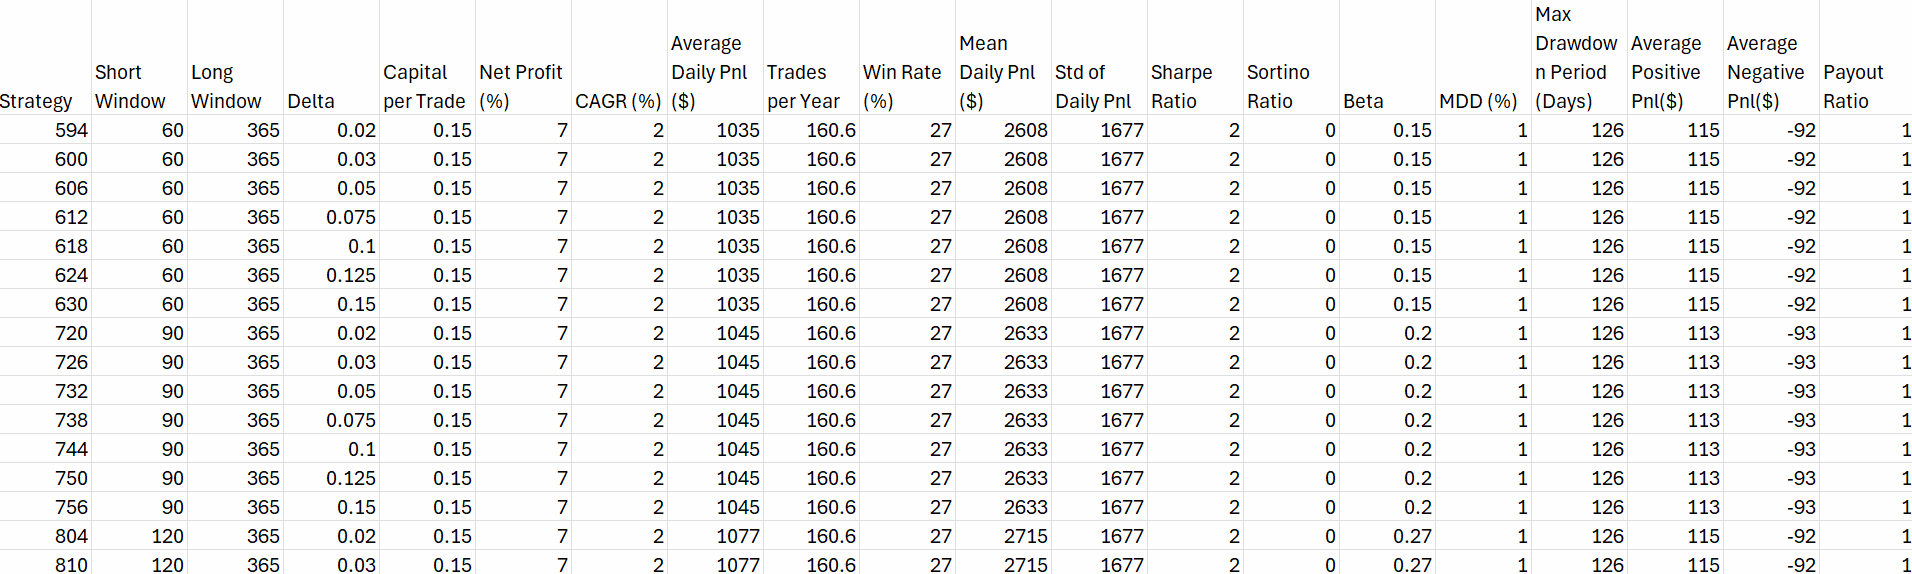

## Further analyse this set of  parameters
- Short window = 60
- Long window = 365
- Delta = 2%
- Capital per trade = 15%

Net Profit = 7%
CAGR = 2%
Average daily profit = $1035
Total number of trades per year =  160.6
Win rate = 27%
Mean of Daily Pnl = $2608
Standard Deviation of Daily Pnl = 1677
Average Positive Pnl($) =  115
Average Negative Pnl($) =  -92
Payout Ratio =  1
Sharpe Ratio = 2%
Sortino Ratio = 0%
Beta =  0.15


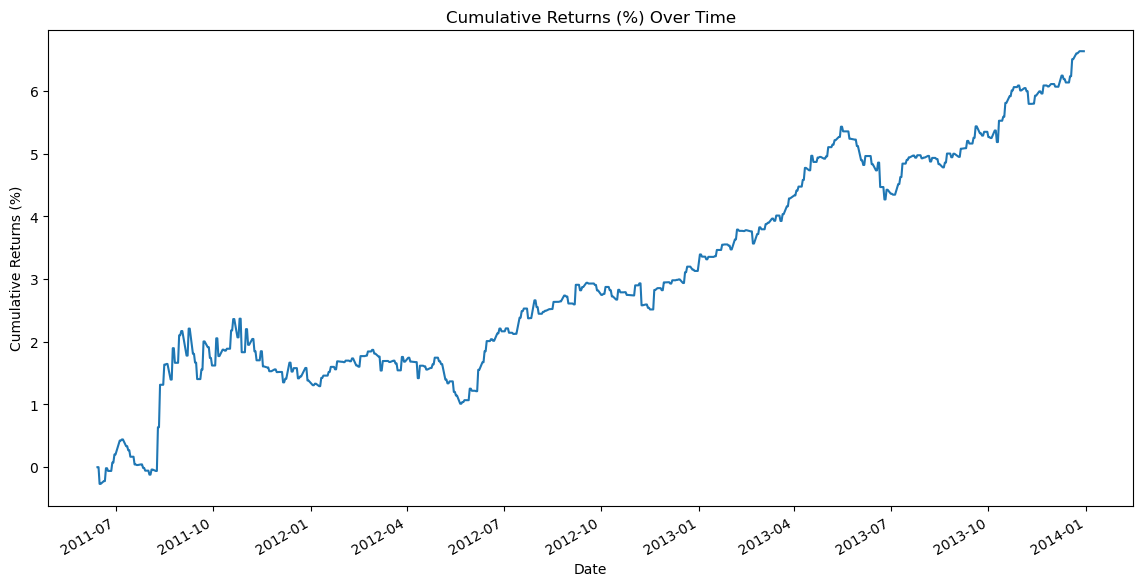

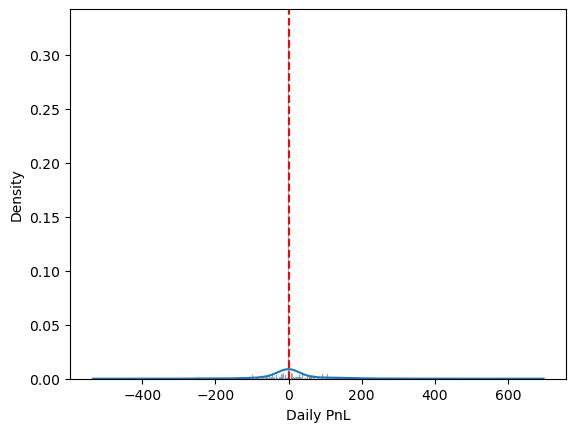

Max Drawdown (%) = 1%


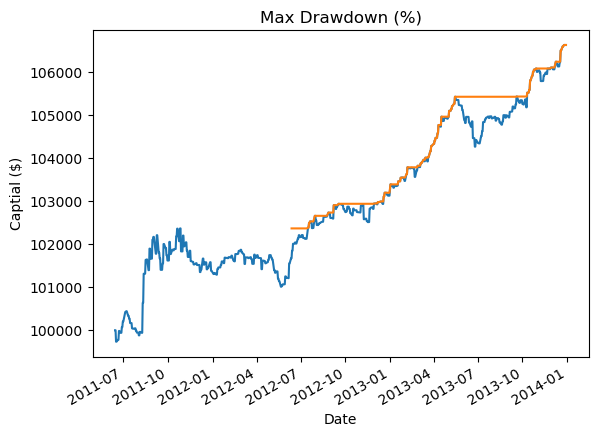

,Drawdown Period (Days),Max Drawdown (%),Start,End
0,126.0,1.100602,2013-05-16,2013-09-19
1,72.0,0.413354,2012-09-18,2012-11-29
2,27.0,0.208374,2012-07-31,2012-08-27
3,23.0,0.275663,2013-10-30,2013-11-22
4,21.0,0.237697,2013-09-20,2013-10-11


Max Drawdown Period = 126.0 days


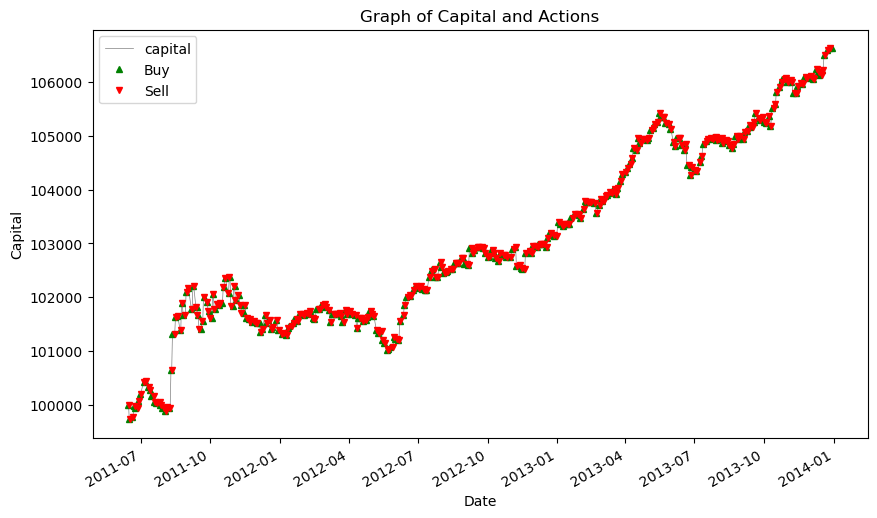

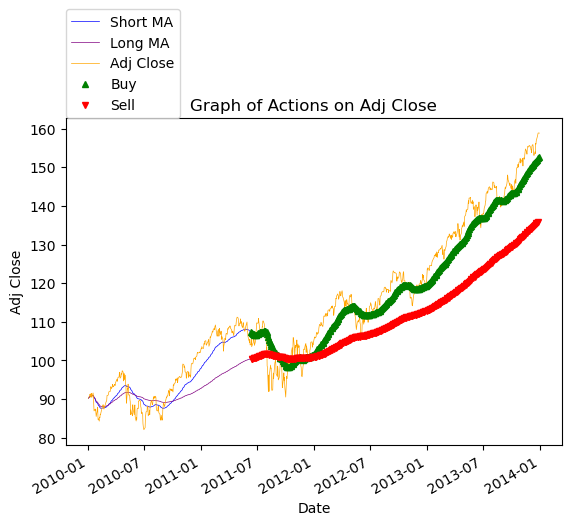

In [8]:
short_window = 60
long_window = 365
delta = 0.02  
capital = 100000
capital_per_trade = 0.15 

df = pd.read_csv('SPY (2003-01 - 2021-11).csv')
df = df[['Date','Adj Close']]
df = df[(df['Date'] >= '2010-01-04') & (df['Date'] <= '2013-12-30') ]

df['short_ma'] = df['Adj Close'].ewm(span=short_window).mean()
df['long_ma'] = df['Adj Close'].ewm(span=long_window).mean()
backtest(df, short_window, long_window, delta, capital, capital_per_trade)

## Observations
- SMA and EMA give similar result. Adding an "exponential" component does not add value

# Linearly Weighted Moving Average (WMA)
- The WMA assigns a linearly increasing weight to prices over the period, with more recent prices given higher weights
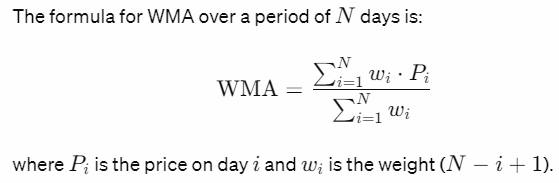

In [ ]:
def calculate_wma(df, column_name, window):
    weights = pd.Series(range(1, window+1))  # Linearly increasing weights
    wma = df[column_name].rolling(window=window).apply(lambda prices: np.dot(prices, weights)/weights.sum(), raw=True)
    return wma

def strategy3(df, strategy_num, short_window, long_window, delta, capital_per_trade):
    res = [strategy_num, short_window, long_window, delta, capital_per_trade]
    
    capital = 100000

    df['short_ma'] = calculate_wma(df, 'Adj Close', short_window)
    df['long_ma'] = calculate_wma(df, 'Adj Close', long_window)
    
    df['position'] = 0  # 1 = long, -1 = short, 0 = no position

    df=df.reset_index(drop=True)

    for i in range(long_window-1, len(df)):
        if df.loc[i-1, 'position'] == 0:
            if df.loc[i, 'short_ma'] > df.loc[i, 'long_ma']:
                df.loc[i, 'position'] = 1
            elif df.loc[i, 'short_ma'] < df.loc[i, 'long_ma']:
                df.loc[i, 'position'] = -1

        elif df.loc[i-1, 'position'] == 1:

            if df.loc[i, 'Adj Close'] < df.loc[i-1, 'Adj Close'] * (1 - delta) or \
               df.loc[i, 'short_ma'] < df.loc[i, 'long_ma']:
                df.loc[i, 'position'] = 0

        elif df.loc[i-1, 'position'] == -1:

            if df.loc[i, 'Adj Close'] > df.loc[i-1, 'Adj Close'] * (1 + delta) or \
               df.loc[i, 'short_ma'] > df.loc[i, 'long_ma']:
                df.loc[i, 'position'] = 0

    df.loc[long_window-2, 'position'] = 0.0
    position_diff = df['position'].diff()
    df['action'] = np.where(position_diff > 0, 1, np.where(position_diff < 0, -1, 0)) # When position_diff > 0, assign 1; when position_diff < 0, assign -1; otherwise, assign 0

    df['position'] = df['position'].shift() 

    df.loc[long_window-1, 'position'] = 0.0
    df['close_change_pct'] = df['Adj Close'].pct_change()

    df['capital'] = np.nan # df['capital'] shows the capital at close at each datetime inde
    df.loc[long_window-1,'capital'] = capital

    for i in range(long_window-1, len(df)):
        dollar_pnl = df.loc[i,'position'] * df.loc[i,'close_change_pct'] * df.loc[i, 'capital'] * capital_per_trade
        df.loc[i+1, 'capital'] = df.loc[i, 'capital'] + dollar_pnl

    df['daily_pnl'] = df['capital'].diff()
    df['cum_ret'] = ((df['capital'] - capital) / capital) *100

    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True) # Set 'Date' as the index of the DataFrame

    metrics_res = performance_metrics3(df, res, capital)    

In [21]:
df = pd.read_csv('SPY (2003-01 - 2021-11).csv')
df = df[['Date','Adj Close']]
df = df[(df['Date'] >= '2010-01-04') & (df['Date'] <= '2013-12-30') ]

short_windows = [10, 30, 60, 90, 120, 180,]
long_windows = [30, 60, 90, 120, 180, 365]
deltas = [0.02, 0.03, 0.05, 0.075, 0.1, 0.125, 0.15]
capital_per_trades = [0.02, 0.05, 0.075, 0.1, 0.125, 0.15]

strategy_num = 1
for params in itertools.product(short_windows, long_windows, deltas, capital_per_trades):
    short_window, long_window, delta, capital_per_trade = params
    if long_window > short_window:
        strategy3(df.copy(), strategy_num, short_window, long_window, delta, capital_per_trade)
        strategy_num+=1
    else:
        continue

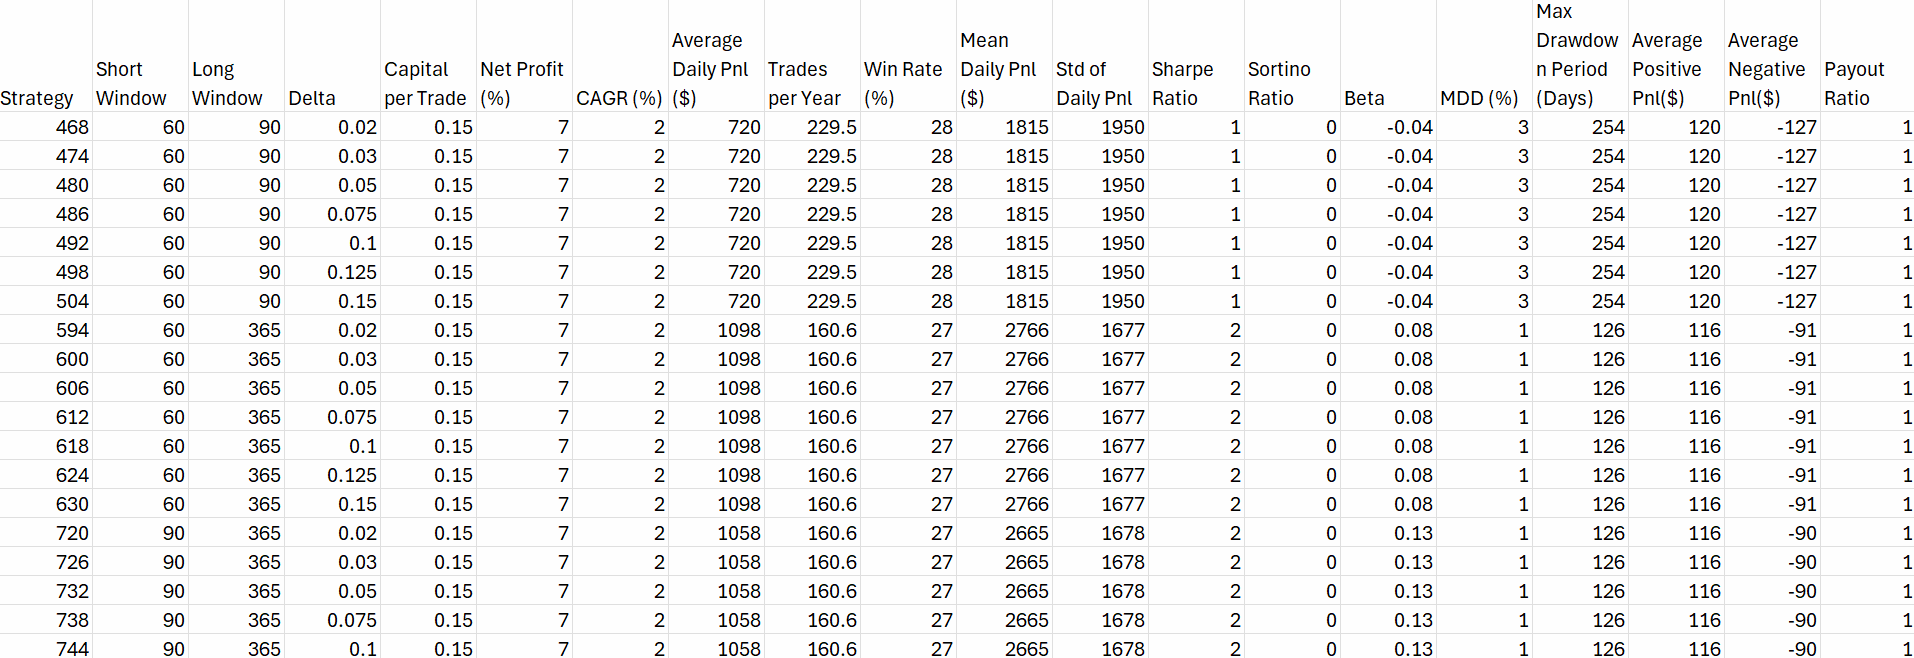

## Observations
- The best SMA and EMA parameters give a net profit of 7-8%, with 160 trades per year and a long window of 365 days.
- The best WMA paramters gives a net profit of 7%, but the trades per year is 229 and long window is 90, 

# Smoothed Moving Average (SMMA)
- The SMMA is similar to an Exponential Moving Average (EMA) but uses a longer period to smooth the data more effectively. It is calculated using a recursive formula that incorporates the previous period's SMMA value
- This formula effectively smooths out the moving average over time by blending the current price with the previous average.
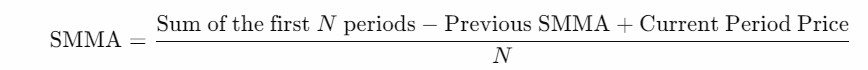

In [22]:
def calculate_smma(df, column_name, window):
    smma = df[column_name].copy()
    smma.iloc[:window] = smma.iloc[:window].mean()  # First value is just an average
    for i in range(window, len(smma)):
        smma.iloc[i] = (smma.iloc[i-1] * (window - 1) + smma.iloc[i]) / window
    return smma

def strategy3(df, strategy_num, short_window, long_window, delta, capital_per_trade):
    res = [strategy_num, short_window, long_window, delta, capital_per_trade]
    
    capital = 100000
    
    df['short_ma'] = calculate_smma(df, 'Adj Close', short_window)
    df['long_ma'] = calculate_smma(df, 'Adj Close', long_window)
    
    df['position'] = np.nan  

    df=df.reset_index(drop=True)

    for i in range(long_window-1, len(df)):
        if np.isnan(df.loc[i-1, 'position']):
            if df.loc[i, 'short_ma'] > df.loc[i, 'long_ma']:
                df.loc[i, 'position'] = 1
            elif df.loc[i, 'short_ma'] < df.loc[i, 'long_ma']:
                df.loc[i, 'position'] = -1

        elif df.loc[i-1, 'position'] == 1:

            if df.loc[i, 'Adj Close'] < df.loc[i-1, 'Adj Close'] * (1 - delta) or \
               df.loc[i, 'short_ma'] < df.loc[i, 'long_ma']:
                df.loc[i, 'position'] = np.nan

        elif df.loc[i-1, 'position'] == -1:

            if df.loc[i, 'Adj Close'] > df.loc[i-1, 'Adj Close'] * (1 + delta) or \
               df.loc[i, 'short_ma'] > df.loc[i, 'long_ma']:
                df.loc[i, 'position'] = np.nan

    df['position'].ffill(inplace=True)
    df.loc[long_window-2, 'position'] = 0.0
    position_diff = df['position'].diff()
    df['action'] = np.where(position_diff > 0, 1, np.where(position_diff < 0, -1, 0)) # When position_diff > 0, assign 1; when position_diff < 0, assign -1; otherwise, assign 0

    df['position'] = df['position'].shift() 

    df.loc[long_window-1, 'position'] = 0.0
    df['close_change_pct'] = df['Adj Close'].pct_change()

    df['capital'] = np.nan # df['capital'] shows the capital at close at each datetime inde
    df.loc[long_window-1,'capital'] = capital

    for i in range(long_window-1, len(df)):
        dollar_pnl = df.loc[i,'position'] * df.loc[i,'close_change_pct'] * df.loc[i, 'capital'] * capital_per_trade
        df.loc[i+1, 'capital'] = df.loc[i, 'capital'] + dollar_pnl

    df['daily_pnl'] = df['capital'].diff()
    df['cum_ret'] = ((df['capital'] - capital) / capital) *100

    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True) # Set 'Date' as the index of the DataFrame

    metrics_res = performance_metrics3(df, res, capital)

In [23]:
df = pd.read_csv('SPY (2003-01 - 2021-11).csv')
df = df[['Date','Adj Close']]
df = df[(df['Date'] >= '2010-01-04') & (df['Date'] <= '2013-12-30') ]

short_windows = [10, 30, 60, 90, 120, 180,]
long_windows = [30, 60, 90, 120, 180, 365]
deltas = [0.02, 0.03, 0.05, 0.075, 0.1, 0.125, 0.15]
capital_per_trades = [0.02, 0.05, 0.075, 0.1, 0.125, 0.15]

strategy_num = 1
for params in itertools.product(short_windows, long_windows, deltas, capital_per_trades):
    short_window, long_window, delta, capital_per_trade = params
    if long_window > short_window:
        strategy3(df.copy(), strategy_num, short_window, long_window, delta, capital_per_trade)
        strategy_num+=1
    else:
        continue

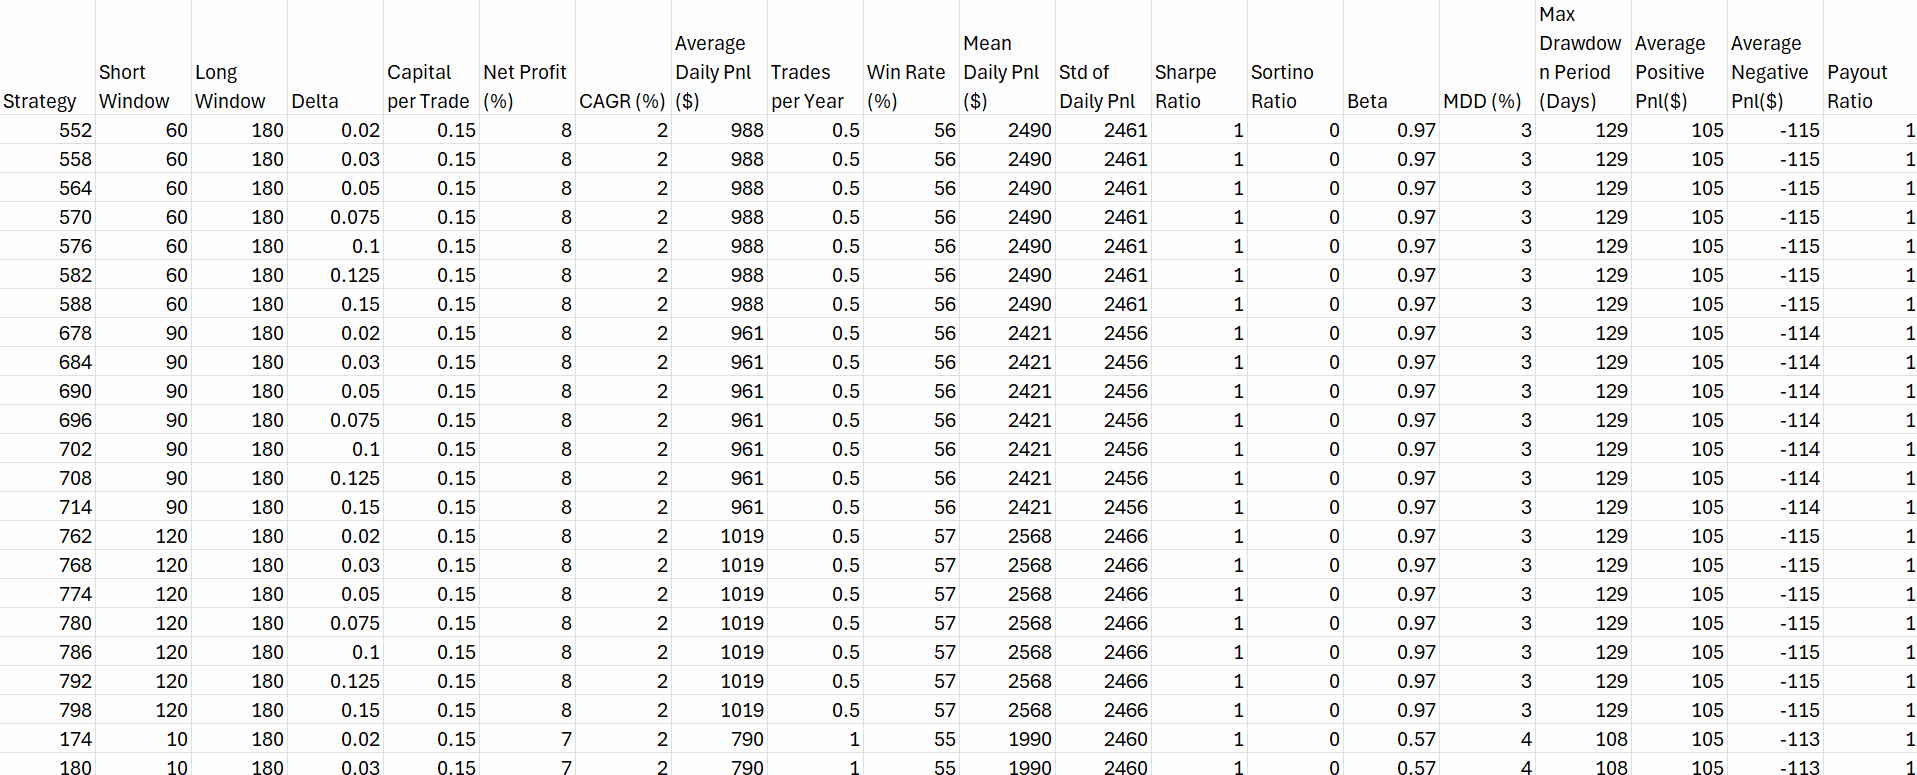

<font color='red'> SMMA also gives a net profit of 8%. **Strategy 1 to 3 explored various types of moving averages (including SMA, EMA, WMA, SMMA). Their trades are essentially the same. There are no significant added value to deviate from the simplest base model of SMA**

<a id='strategy4'></a>
# Strategy 4
- Machine Learning (ML)-based Moving Average (MA) strategy

## Features
- lagged Adj Close
- Volume
    - High volume and strong directional movement may suggest strong market conviction and momentum. In this case, high volume coincides with the market downturns
    - 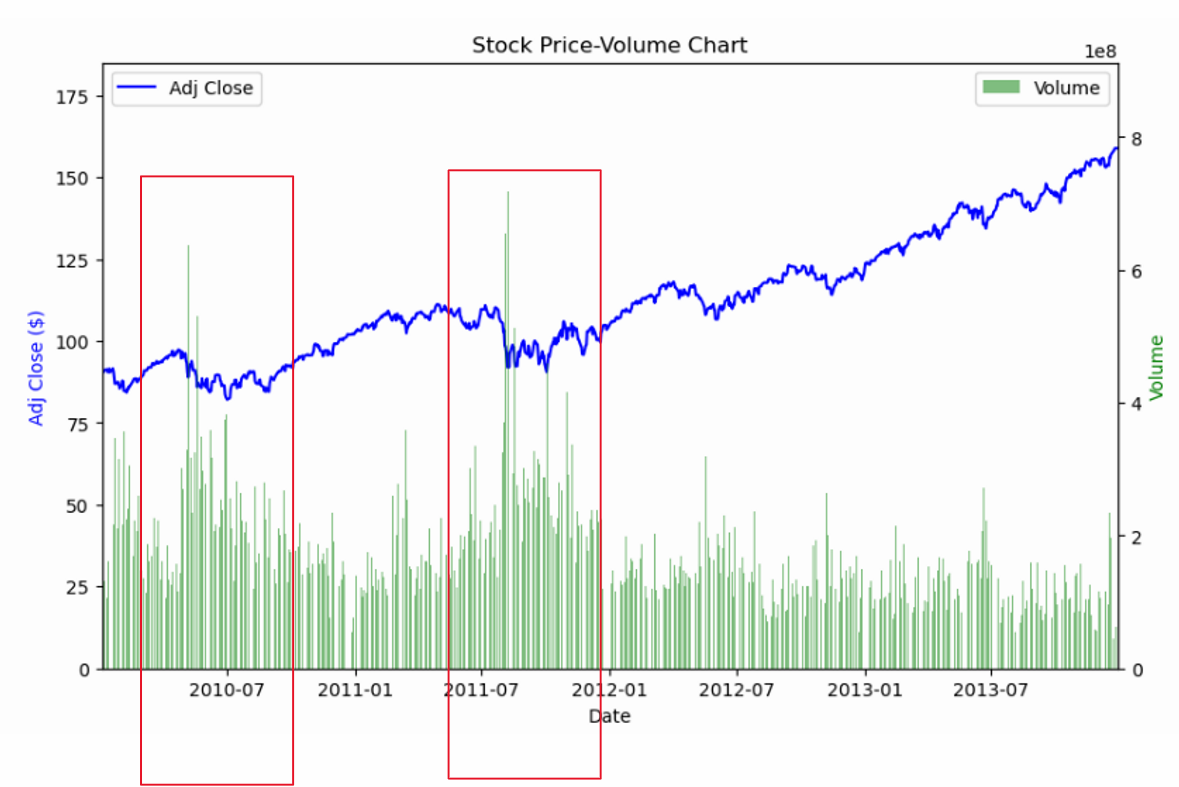
- US 2Y10Y Spread
- ICE US Dollar Index
- WTI Index
- CBOE VIX Index

In [118]:
df = pd.read_csv('SPY (2003-01 - 2021-11).csv')
df = df[(df['Date'] >= '2010-01-04') & (df['Date'] <= '2013-12-30') ]
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

vix = pd.read_csv('VIX.csv', parse_dates=['DATE'], index_col='DATE').loc['2010-01-04':'2013-12-30']
us0210y = pd.read_csv('US0210Y.csv', parse_dates=['DATE'], index_col='DATE').loc['2010-01-04':'2013-12-30']
wti = pd.read_csv('WTI.csv', parse_dates=['DATE'], index_col='DATE').loc['2010-01-04':'2013-12-30']

start_date = datetime(2010,1,4)
end_date = datetime(2013,12,31)
dxy = yf.download('DX-Y.NYB', start=start_date, end=end_date)

display(vix)
display(us0210y)
display(wti)
display(dxy)

[*********************100%%**********************]  1 of 1 completed


,Vix
DATE,
2010-01-04,20.04
2010-01-05,19.35
2010-01-06,19.16
2010-01-07,19.06
2010-01-08,18.13
...,...
2013-12-24,12.48
2013-12-25,.
2013-12-26,12.33


,US0210Y
DATE,
2010-01-04,2.76
2010-01-05,2.76
2010-01-06,2.84
2010-01-07,2.82
2010-01-08,2.87
...,...
2013-12-24,2.61
2013-12-25,NaN
2013-12-26,2.58


,WTI
DATE,
2010-01-04,81.52
2010-01-05,81.74
2010-01-06,83.12
2010-01-07,82.6
2010-01-08,82.74
...,...
2013-12-24,98.87
2013-12-25,.
2013-12-26,99.18


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,77.930000,78.190002,77.260002,77.529999,77.529999,0
2010-01-05,77.370003,77.709999,77.089996,77.620003,77.620003,0
2010-01-06,77.650002,78.000000,77.360001,77.489998,77.489998,0
2010-01-07,77.370003,78.080002,77.300003,77.910004,77.910004,0
2010-01-08,77.980003,78.190002,77.349998,77.470001,77.470001,0
...,...,...,...,...,...,...
2013-12-23,80.550003,80.550003,80.320000,80.449997,80.449997,0
2013-12-24,80.440002,80.620003,80.430000,80.529999,80.529999,0
2013-12-26,80.610001,80.620003,80.449997,80.480003,80.480003,0


# Among multiple predictive models (e.g. ML, linear regression and ARIMA), determine the best model
- Model
    - Y = c + b1X1 + b2X2 + b3X3 + b
- Input features
    - c : constant / intercept
    - X1: VIX
    - X2: US10Y
    - X3: WTI
    - X4: Adj Close of DXY
    - X5: Volume of SPY
    - X6: SPY Adj Close lag 5
    - X7: SPY Adj Close lag 10
    - X8: SPY Adj Close lag 15

# 5 Steps of Supervised Machine Learning (ML)
- Step 1: data split
- Step 2: feature engineering 
- Step 3: model specification
- Step 4: hyperparameter tuning (beware of overfitting)
- Step 5: assessment

## Step 1 and 2: data split and feature engineering

In [119]:
return_period = 5 
testing_set_pct = 0.25

In [120]:
df = df.join([vix['Vix'].rename('VIX'), 
              us0210y['US0210Y'].rename('US0210Y'), 
              wti['WTI'].rename('WTI'), 
              dxy['Adj Close'].rename('DXY_Adj_Close')])

df['lag5'] = df['Adj Close'].shift(-5)
df['lag10'] = df['Adj Close'].shift(-10)
df['lag15'] = df['Adj Close'].shift(-15)

df = df[['VIX', 'US0210Y', 'WTI', 'DXY_Adj_Close', 'Volume', 'lag5', 'lag10', 'lag15', 'Adj Close']]
df = df.dropna()
df = df.apply(pd.to_numeric, errors='coerce')

In [121]:
df

,VIX,US0210Y,WTI,DXY_Adj_Close,Volume,lag5,lag10,lag15,Adj Close
Date,,,,,,,,,
2010-01-04,20.04,2.76,81.52,77.529999,118944600.0,91.319366,91.582016,87.005295,90.205017
2010-01-05,19.35,2.76,81.74,77.620003,111579900.0,90.467712,90.650757,87.419189,90.443787
2010-01-06,19.16,2.84,83.12,77.489998,116074400.0,91.231812,88.907585,86.416298,90.507515
2010-01-07,19.06,2.82,82.60,77.910004,131091100.0,91.478531,86.925697,85.477089,90.889542
2010-01-08,18.13,2.87,82.74,77.470001,126402800.0,90.451752,87.371437,86.806313,91.191986
...,...,...,...,...,...,...,...,...,...
2013-12-02,14.23,2.51,93.61,80.910004,99726000.0,155.897522,154.024017,157.720306,155.149857
2013-12-03,14.55,2.51,95.83,80.620003,116563000.0,155.338867,153.534119,158.065933,154.479462
2013-12-04,14.70,2.54,96.97,80.629997,123033000.0,153.594284,156.155334,158.869553,154.462311


In [122]:
res = {}

# Logarithmic Returns to normalize the price data and to make the returns scale-free (percentage change)
Y = np.log(df.loc[ : , 'Adj Close']).diff(return_period)
Y.name = Y.name+" pred"

In [123]:
X1 = np.log(df['VIX']).diff(return_period)
X2 = np.log(df['US0210Y']).diff(return_period)
X3 = np.log(df['WTI']).diff(return_period)
X4 = np.log(df['DXY_Adj_Close']).diff(return_period)
X5 = np.log(df['Volume']).diff(return_period)
X6 = np.log(df['lag5']).diff(return_period)
X7 = np.log(df['lag10']).diff(return_period)
X8 = np.log(df['lag15']).diff(return_period)
X = pd.concat([X1, X2, X3, X4, X5, X6, X7, X8], axis=1).dropna()
X

,VIX,US0210Y,WTI,DXY_Adj_Close,Volume,lag5,lag10,lag15
Date,,,,,,,,
2010-01-11,-0.132676,0.049480,0.012435,-0.006860,-0.111681,0.002872,-0.051266,0.009741
2010-01-12,-0.058527,0.021506,-0.011690,-0.008669,0.381053,0.002021,-0.036299,0.000000
2010-01-13,-0.070821,-0.003527,-0.042518,-0.008293,0.332266,-0.025806,-0.028421,-0.019813
2010-01-14,-0.077990,0.000000,-0.040141,-0.015262,-0.124729,-0.051051,-0.016805,-0.006821
2010-01-15,-0.012209,-0.021128,-0.059507,-0.001938,0.518447,-0.034648,-0.006489,-0.029497
...,...,...,...,...,...,...,...,...
2013-12-02,0.149010,0.028285,-0.009780,0.002475,0.204330,0.004807,-0.012090,0.023715
2013-12-03,0.128927,0.028285,0.020771,-0.003714,0.382851,0.005548,-0.011686,0.029089
2013-12-04,0.137621,0.048397,0.037403,0.000248,0.346613,-0.005636,0.016537,0.017232


In [105]:
data =pd.concat([Y, X],axis = 1).dropna().iloc[ : :return_period, :]

In [86]:
Y = data.loc[ : , Y.name]
Y

Date
2010-01-11    0.012278
2010-01-19    0.002872
2010-01-26   -0.051266
2010-02-02    0.009741
2010-02-09   -0.029046
                ...   
2013-11-05   -0.005093
2013-11-13    0.011899
2013-11-20    0.000504
2013-11-27    0.014739
2013-12-05   -0.012109
Name: Adj Close pred, Length: 196, dtype: float64

In [87]:
X = data.loc[ : , X.columns]
X

,VIX,US0210Y,WTI,DXY_Adj_Close,Volume,lag5,lag10,lag15
Date,,,,,,,,
2010-01-11,-0.132676,0.049480,0.012435,-0.006860,-0.111681,0.002872,-0.051266,0.009741
2010-01-19,0.001708,-0.035091,-0.044088,0.006473,0.268738,-0.051266,0.009741,-0.029046
2010-01-26,0.333950,-0.007168,-0.056116,0.011929,0.416942,0.009741,-0.029046,0.027958
2010-02-02,-0.133590,0.010734,0.033451,0.007368,0.024137,-0.029046,0.027958,0.005066
2010-02-09,0.190974,0.007092,-0.046391,0.010701,0.445719,0.027958,0.005066,0.013266
...,...,...,...,...,...,...,...,...
2013-11-05,-0.010495,0.065383,-0.051031,0.013472,-0.018196,0.003907,0.011630,0.009174
2013-11-13,-0.058178,0.025001,0.005446,0.002722,0.190579,0.008497,0.011606,-0.009677
2013-11-20,0.067927,0.036368,-0.006088,0.002222,0.184696,0.014739,-0.012109,-0.004537


In [88]:
train_size = int(len(X)*(1 - testing_set_pct))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]
scoring = "neg_mean_squared_error" # Ten-fold Cross Validation and Evaluation Metrics

## Step 3: model specification

In [89]:
models = []

###### Regression and tree regression algorithm
models.append(("LR", LinearRegression()))
models.append(("LASSO", Lasso()))
models.append(("EN", ElasticNet()))
models.append(("CART", DecisionTreeRegressor())) 
models.append(("KNN", KNeighborsRegressor()))
models.append(("SVR", SVR())) 

###### Ensemble models 
models.append(("RFR", RandomForestRegressor()))
models.append(("ETR", ExtraTreesRegressor()))
models.append(("GBR", GradientBoostingRegressor()))
models.append(("ABR", AdaBoostRegressor()))

## Step 5: assessment

In [90]:
trained_models = {}

num_folds = 10
seed = 0

names = []
kfold_results = [] # Cross-validation results, it gives the values from n=10
train_results = [] # Result from training
test_results = [] # If training result better than test result, this suggests overfitting

for name, model in models:
    names.append(name)
    kfold = KFold(n_splits = num_folds, random_state = seed, shuffle = True)

    # Run K-Folds Cross-Validation
    cv_results =-1*cross_val_score(model, X_train, Y_train,cv = kfold,scoring = scoring) # Convert MSE to negative MSE. The higher the negative MSE, the better the model
    kfold_results.append(cv_results) 

    # Fitting the Model on the Training Se
    res = model.fit(X_train, Y_train) 
    
    # Evaluating Model on Training Set
    train_result = mean_squared_error(res.predict(X_train), Y_train) # Predictions on the training set are evaluated using the MSE
    train_results.append(train_result)
    
    # Evaluating Model on Testing Set  
    test_result = mean_squared_error(res.predict(X_test), Y_test) 
    test_results.append(test_result)
    message = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(message)
    
    trained_models[name] = model

LR: 0.000197 (0.000111) 0.000154 0.000112
LASSO: 0.000841 (0.000724) 0.000820 0.000236
EN: 0.000841 (0.000724) 0.000820 0.000236
CART: 0.000422 (0.000271) 0.000000 0.000155
KNN: 0.000367 (0.000336) 0.000210 0.000074
SVR: 0.001681 (0.000542) 0.001727 0.001358
RFR: 0.000250 (0.000234) 0.000033 0.000079
ETR: 0.000221 (0.000213) 0.000000 0.000083
GBR: 0.000241 (0.000248) 0.000009 0.000073
ABR: 0.000255 (0.000228) 0.000075 0.000069


### Boxplot of the Results of K-Folds Cross Validation
- Boxplot compares distribution of negative MSE of different ML models. The higher negative MSE, the better the model
- Boxplot shows median, quartiles, and potential outliers
- Generally speaking, a good model has high median value, small IQR and few outliers, which suggest the model performs well under different situations. In this case, it suggests that the model offers good prediction of the SPY Index under different economic environments. 
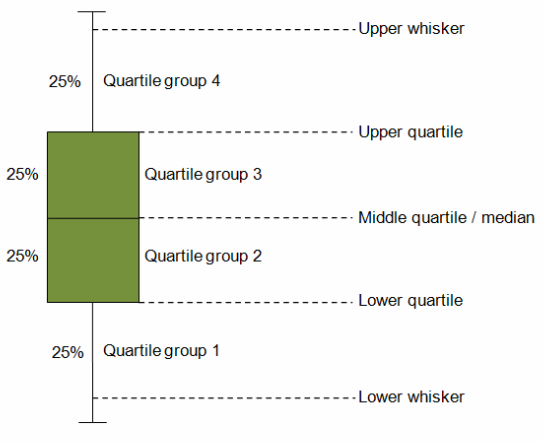

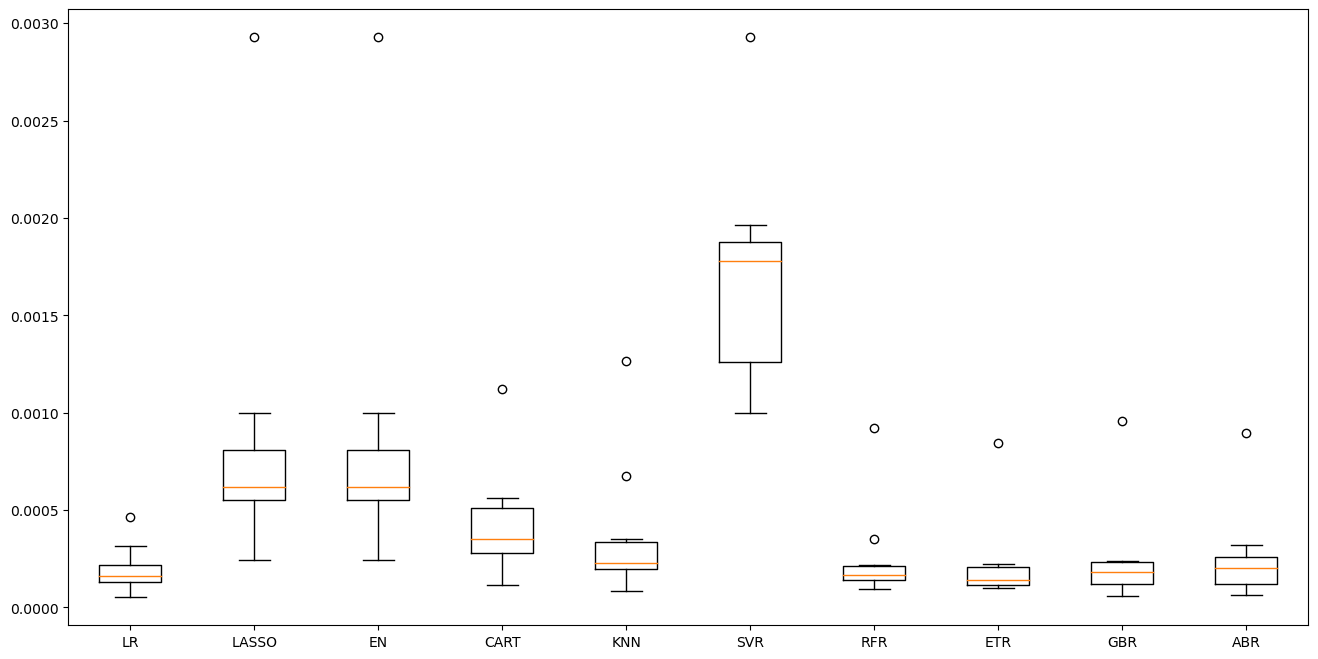

In [91]:
fig = plt.figure(figsize = [16, 8])
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
_ = ax.set_xticklabels(names)

### Observations
- Model with the highest median (i.e. line-in-box) suggest it performs the best on average
    - **SVR** has substantially higher median than other models
- Models with median close to 0 means their performance is consistent across different subsets of training data
    - In this case, they are: LR, CART, KNN, RFR, ETR, GBR, ABR
- Low interquartile range (IQR) and less outliers (whiskers) suggests reliability as model is not undesirably sensitive to specific splits of training data.
    - Comparing LASSO, EN and SVR. It is observed that SVR has higher IQR, but even the lower quartile of SVR is higher than the upper quartile of the other three models.
- If median is not centered in box, data is skewed, which means the model performs differently under different conditions
    - Median of SVR is not substantially away from the center of box
    
<font color='red'> SVR performs substantially better than other models in K-Folds Cross Validation. On a side note, SVR is a relatively older ML model, and its performance is highly dependent on the choice of kernel and other hyperparameters such as C (regularization parameter) and gamma (kernel coefficient for 'rbf', 'poly' and 'sigmoid'). Finding the right combination of these hyperparameters can be time-consuming and computationally expensive, especially if the dataset is large. </font>

## ARIMA
- Hyperparameter tuning: grid search for ARIMA. 

In [ ]:
def assess_ARIMA_model(arima_order):
    modelARIMA = stats.ARIMA(endog = Y_train, exog = X_train_ARIMA, order = arima_order)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error

def assess_models(p_values, d_values, q_values): 
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = assess_ARIMA_model(order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print(f"ARIMA{order}, MSE = {mse:7f}")
                except:
                    continue
            
    print(f"Best ARIMA{best_cfg}, MSE = {best_score:7f}") # Best ARIMA ahs the smallest MSE

p_values = [0, 1, 2] # going 3 or higher for p,d or q does not making logical sense and is challenging to interpret
d_values = [0, 1, 2]
q_values = [0, 1, 2]
assess_models(p_values, d_values, q_values)

<font color='red'> ARIMA(2,0,1) is the most optimal. Compare this specific ARIMA against other ML models. </font>

In [ ]:
X_train_ARIMA = X_train.loc[:]
X_test_ARIMA = X_test.loc[:]

train_len = len(X_train_ARIMA)
test_len = len(X_test_ARIMA)
total_len = len(X)
modelARIMA = stats.ARIMA(endog = Y_train,exog = X_train_ARIMA,
                order = [2, 0, 1]) #p,d,q 
                # p denotes the order of Auto Regression (AR) polynomials
                # d denotes the number of nonseasonal differences needed for stationarity
                # q denotes the oder of Moving Average (MA) polynomials

model_fit = modelARIMA.fit()
error_training_ARIMA =mean_squared_error(Y_train,model_fit.fittedvalues)
predicted =model_fit.predict(start = train_len - 1, end = total_len - 1, exog = X_test_ARIMA)[1: ] # [1:] as we are interested in the predicted value of SPY Adj Close

error_testing_ARIMA =mean_squared_error(Y_test,predicted)
print('ARIMA training MSE = ', error_training_ARIMA)
print('ARIMA testing MSE = ', error_testing_ARIMA)

test_results = np.concatenate((test_results, [error_testing_ARIMA]))
train_results = np.concatenate((train_results, [error_training_ARIMA]))

names.append("ARIMA")

### Plotting training and testing performance

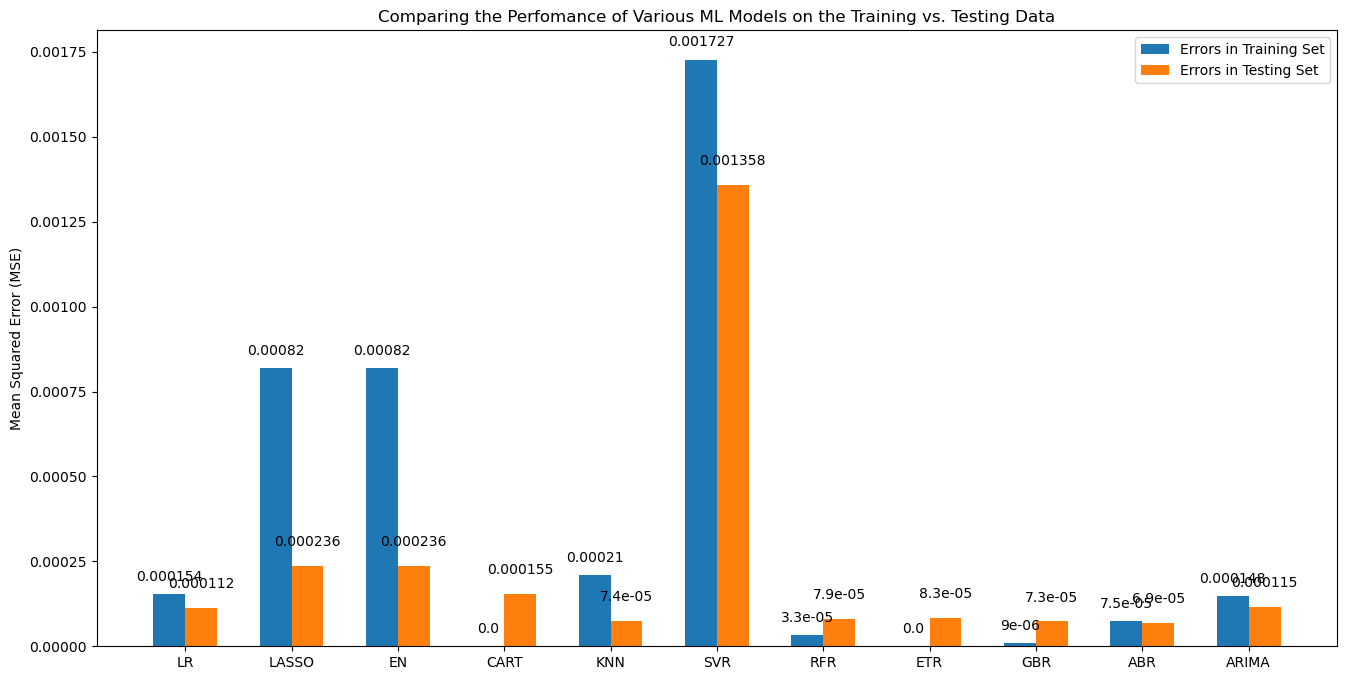

In [94]:
fig = plt.figure(figsize=[16, 8])
ind = np.arange(len(names))
width = 0.30
ax = fig.add_subplot()

# Plotting bars
bars_train = plt.bar(ind - width/2, train_results, width=width, label="Errors in Training Set") # left training bar
bars_test = plt.bar(ind + width/2, test_results, width=width, label="Errors in Testing Set")  # right bar is training bar

# Adding labels to bars
for bar in bars_train:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.00003, round(yval, 6), ha='center', va='bottom')

for bar in bars_test:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.00005, round(yval, 6), ha='center', va='bottom')

# Other formatting
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.title('Comparing the Perfomance of Various ML Models on the Training vs. Testing Data')
plt.ylabel("Mean Squared Error (MSE)")
plt.show()

### Observations

- The training and testing MSE of **SVR** are much worst than other models. This is in sharp contrast to the top performance of SVR in K-Folds Cross Validation. This means that SVR performs best on average across different subsets, but when feed the earliest 75% data for training, and tested on later 25% data for testing, it is the worst. **The high inconsistency in performance makes SVR less suitable to be used in this case**
- Choose the model that (1) has low testing error (suggests that the model is generalised for unseen data), and (2) testing error is not much higher than training error (suggests that the model is not overfitted to the training data)
    - LASSO, EN and SVR have much higher testing error than others. The training and testing MSE for the other models are roughly the same. <font color='red'> The conclusion of testing the 11 models is that I will further analyse **Linear Regression (LR)** as (1) it has low testing MSE, (2) it is not overfitted (as its testing MSE is lower than its training MSE), and (3) it is the simplest model </font>
